### **Automotive Diagnostic Scantool Communication Analysis**  
This project investigates communication issues and vehicle coverage gaps in an automotive diagnostic scantool. The goal is to improve diagnostic scan success rates and customer support efficiency.

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statistics
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")

In [3]:
vci_connections_df = pd.read_excel('../Data/DiagUsage_Cleaned.xlsx', sheet_name='connect_system')

In [4]:
vci_connections_df.sample(5)

,timestamp,siteId,OsName,client_OS,vin,year,make,model,system,veh_desc,vci_version,scan_method,batt_voltage,result,state,city,product_type,postal_code,system_category
48033,2024-10-23 13:56:19.356,873869,iPadOS,iPadOS 16.7.10,KNDPUCAFXP7,2023,Kia,Sportage,Enhanced Powertrain UDS - T-GDI Theta III 2.5L,2023 Kia Sportage 2.5L GDI Enhanced Powertrain...,22.3.2439.2,quick_scan,12.687064,1,ON,BARRIE,COLLISION,L4N 2M3,Enhanced Powertrain
146149,2025-01-20 15:20:48.963,245163,Android,Android 14,7FARW1H98KE,2019,Honda,CR-V,Enhanced Powertrain,2019 Honda CR-V Enhanced Powertrain,22.3.2439.2,quick_scan,14.130000,1,unknown,unknown,unknown,unknown,Enhanced Powertrain
92600,2024-10-24 19:19:35.675,557351,iOS,iOS 17.6.1,1LNHL9DK7DG,2013,Lincoln,MKS,Enhanced Powertrain CAN,2013 Lincoln MKS Enhanced Powertrain CAN,22.1.2418.1,manual scan,13.750000,1,AR,Hot Springs,COLLISION,71901-6565,Enhanced Powertrain
89361,2024-10-19 00:22:06.247,48118,Android,Android 14,1J4GZ58S0VC,1997,Jeep,Grand,Anti-Lock Brake System,1997 Jeep Grand Cherokee Anti-Lock Brake System,22.3.2439.2,manual scan,12.687064,0,CO,Fort Lupton,REPAIR,80621-2633,Braking System
109268,2024-11-13 19:56:23.188,545297,Android,Android 8.1.0,1C4RJFJT4GC,2016,Jeep,Grand,Enhanced Powertrain,2016 Jeep Grand Cherokee Enhanced Powertrain,22.3.2439.2,quick_scan,11.550000,1,OH,CANTON,COLLISION,44720-6926,Enhanced Powertrain


In [5]:
#double check that data has been cleaned
num_duplicated = vci_connections_df.duplicated().sum()
print(num_duplicated)

0


In [37]:
#Get time period for the dataset
start_time = vci_connections_df['timestamp'].min()
end_time = vci_connections_df['timestamp'].max()

print(f"Data ranges from {start_time} to {end_time}")

Data ranges from 2024-10-01 20:24:02.463000 to 2025-02-09 16:28:29.957000


In [6]:
vci_connections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171215 entries, 0 to 171214
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        171215 non-null  datetime64[ns]
 1   siteId           171215 non-null  int64         
 2   OsName           171215 non-null  object        
 3   client_OS        171215 non-null  object        
 4   vin              171215 non-null  object        
 5   year             171215 non-null  int64         
 6   make             171215 non-null  object        
 7   model            171215 non-null  object        
 8   system           171215 non-null  object        
 9   veh_desc         171215 non-null  object        
 10  vci_version      171215 non-null  object        
 11  scan_method      171215 non-null  object        
 12  batt_voltage     171215 non-null  float64       
 13  result           171215 non-null  int64         
 14  state            171

In [7]:
#convert year to an int - needed for plotting
vci_connections_df['year'] = vci_connections_df['year'].astype(int)

### Investigate connection success rates by VCI version
The VCI (Vehicle Communications Interface) is the hardware device that communicates with the vehicle. It communicates with a client application via bluetooth

In [8]:
# Convenience function to create a frequency plot for a given feature vs result
# assumes passed in df has a column named 'result' with values 0 or 1
def create_correlation_table(source_df, feature):
    df = pd.crosstab(source_df[feature], source_df['result'])
    df['total'] = df[0] + df[1]
    overall_total = df['total'].sum()
    df['cumulative%'] = (df['total'] / overall_total) * 100
    df['success%'] = (df[1] / df['total']) * 100
    return df

In [9]:
vci_version_df = pd.crosstab(vci_connections_df['vci_version'], vci_connections_df['result'])
vci_version_df['total'] = vci_version_df[0] + vci_version_df[1]
overall_total = vci_version_df['total'].sum()
vci_version_df['percentage'] = (vci_version_df['total'] / overall_total) * 100
vci_version_df['success_rate'] = (vci_version_df[1] / vci_version_df['total']) * 100
vci_version_df['failure_rate'] = 100 - vci_version_df['success_rate']
# Sort by percentage in descending order
vci_version_df = vci_version_df.sort_values(by='percentage', ascending=False)
# Add a cumulative percentage column
vci_version_df['cumulative_percentage'] = vci_version_df['percentage'].cumsum()
# Display the first few rows
vci_version_df

result,0,1,total,percentage,success_rate,failure_rate,cumulative_percentage
vci_version,,,,,,,
22.3.2439.2,9872,73186,83058,48.510937,88.114330,11.885670,48.510937
22.1.2418.1,5449,41426,46875,27.377858,88.375467,11.624533,75.888795
22.1.2411.1,904,8770,9674,5.650206,90.655365,9.344635,81.539001
21.3.2337.1,1107,7966,9073,5.299185,87.798964,12.201036,86.838186
21.2.2323.1,629,6373,7002,4.089595,91.016852,8.983148,90.927781
21.0.2307.1,626,5533,6159,3.597232,89.836012,10.163988,94.525012
22.2.2424.1,449,3742,4191,2.447800,89.286566,10.713434,96.972812
20.3.2237.1,179,1657,1836,1.072336,90.250545,9.749455,98.045148
20.0.2150.1,82,838,920,0.537336,91.086957,8.913043,98.582484


In [10]:
#Too many older VCI software version are still being used by customers! A recommendation is to force customers to upgrade to the latest version of the software. 
# The top 7 versions account for almost 97% percent of connetions. Others will be dropped to prevent issues that may have already been resolved from affecting the model.
#only keep top 7 versions in diag_usage_df
top_versions = vci_version_df.head(7).index.tolist()
vci_connections_df = vci_connections_df[vci_connections_df['vci_version'].isin(top_versions)]
vci_connections_df.shape

(166032, 19)

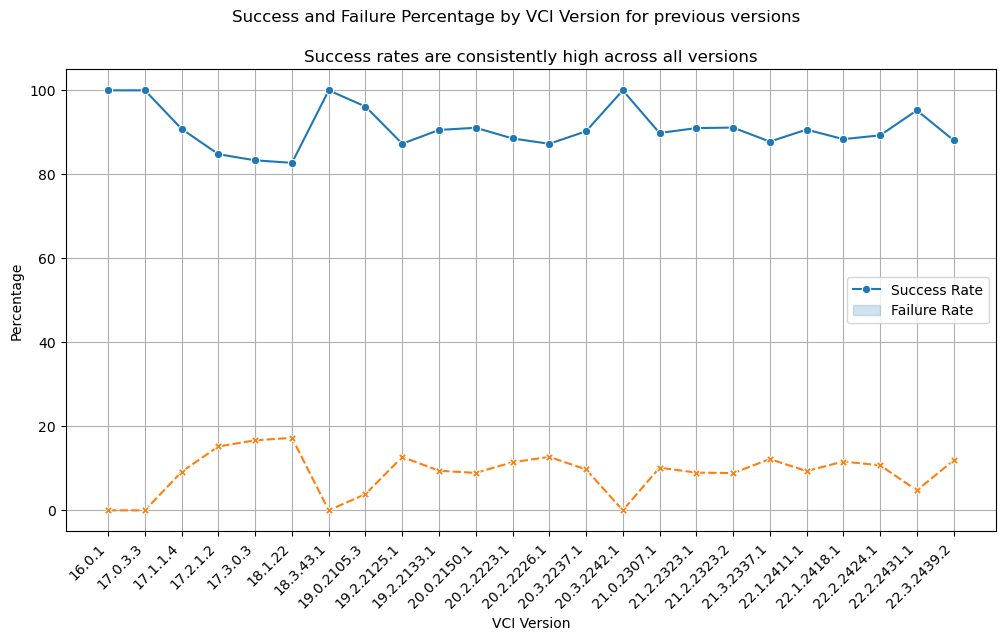

In [11]:
#create line plot of vci connection success rate based on vci version
vci_version_df2 = vci_version_df[['success_rate', 'failure_rate']]
vci_version_df2.sort_index(inplace=True)

#Plotting success and failure rate by VCI version
plt.figure(figsize=(12, 6))
sns.lineplot(data=vci_version_df2, markers=True)

# Formatting the plot
plt.xticks(rotation=45, ha="right")
plt.xlabel("VCI Version")
plt.ylabel("Percentage")
plt.suptitle("Success and Failure Percentage by VCI Version for previous versions")
plt.title("Success rates are consistently high across all versions")
plt.legend(labels=["Success Rate", "Failure Rate"])
plt.grid(True)

## Univariate Analysis of vehicle parameters

In [12]:
vci_connections_df.nunique()

timestamp          166028
siteId               1695
OsName                  4
client_OS              72
vin                 62091
year                   29
make                   47
model                 605
system                872
veh_desc            10276
vci_version             7
scan_method             2
batt_voltage          447
result                  2
state                  65
city                 1196
product_type            3
postal_code          1578
system_category        26
dtype: int64

In [13]:
vci_connections_df.describe().round(2).T

,count,mean,min,25%,50%,75%,max,std
timestamp,166032,2024-12-05 18:53:26.641732608,2024-10-01 20:24:02.463000,2024-11-01 19:42:49.543000064,2024-12-04 17:46:29.576499968,2025-01-09 20:36:49.948999936,2025-02-09 16:28:29.957000,NaN
siteId,166032.0,466752.22,10799.0,257315.0,481739.0,668322.0,888822.0,243847.0
year,166032.0,2017.57,1997.0,2015.0,2018.0,2021.0,2025.0,4.96
batt_voltage,166032.0,12.69,1.48,11.75,12.69,13.78,22.69,1.14
result,166032.0,0.89,0.0,1.0,1.0,1.0,1.0,0.32


In [14]:
#print number of unique vehicle attributes
def print_unique_attributes(df):
    veh_attributes = ['year', 'make', 'model', 'vin', 'veh_desc']
    print(f'Number of entries: {df.shape[0]}')
    for attribute in veh_attributes:
        num_attributes = df[attribute].nunique()
        print(f'Number of unique {attribute}s: {num_attributes}')

In [15]:
#calculate success rate
def calculate_success_rate(df):
    counts = df['result'].value_counts()
    success_percentage = (counts[1] / counts.sum()) * 100
    return success_percentage

In [16]:
#plot success / failure rate for passed in dataframe
def plot_success_failure_rate(df, title):
    scan_counts = df['result'].value_counts()
    success_percentage = (scan_counts[1] / scan_counts.sum()) * 100
    failure_percentage = (scan_counts[0] / scan_counts.sum()) * 100

    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.countplot(x='result', data=df)
    plt.title(title)
    # Add text for success percentage on the plot
    ax.text(0, scan_counts[0] + 0.2, f'{failure_percentage:.1f}%', ha='center', va='bottom', fontsize=12)
    # Add text for failure percentage on the plot
    ax.text(1, scan_counts[1] + 0.2, f'{success_percentage:.1f}%', ha='center', va='bottom', fontsize=12)
    plt.show()

### 80 / 20 analysis. Determine the minimal set of unique parameter values that together account for 80% of the total observations for various features. 

In [17]:
#find the number of unique vehicle attributes that make up 80% of the dataset
percentage = 0.80
veh_attributes = ['year', 'make', 'model', 'vin', 'veh_desc']
veh_attributes_80 = {}
for attribute in veh_attributes:
    num_attributes = vci_connections_df[attribute].nunique()
    print(f'Number of unique {attribute}s: {num_attributes}')
    counts = vci_connections_df[attribute].value_counts(normalize=True)
    cumulative_counts = counts.cumsum()
    cumulative_counts
    # Get the samples that make up XX% of the dataset
    samples_percentage = cumulative_counts[cumulative_counts <= percentage].index.tolist()
    print(f'{len(samples_percentage)} {attribute}s make up {percentage * 100}% of scans')
    ##print(samples_percentage)
    veh_attributes_80[attribute] = samples_percentage

Number of unique years: 29
10 years make up 80.0% of scans
Number of unique makes: 47
11 makes make up 80.0% of scans
Number of unique models: 605
95 models make up 80.0% of scans
Number of unique vins: 62091
33726 vins make up 80.0% of scans
Number of unique veh_descs: 10276
1743 veh_descs make up 80.0% of scans


In [18]:
#Return the attributes that make up XX% of the failures
def get_top_failed_attributes(df, percentage):
    percentage = percentage / 100
    df_zero = df[vci_connections_df['result'] == 0]
    veh_attributes = ['year', 'make', 'model', 'vin', 'veh_desc']
    veh_attributes_percent = {}

    for attribute in veh_attributes:
        num_attributes = df_zero[attribute].nunique()
        print(f'Number of unique {attribute}s: {num_attributes}')
        counts = df_zero[attribute].value_counts(normalize=True)
        cumulative_counts = counts.cumsum()
        # Get the samples that make up XX% of the dataset
        samples_percentage = cumulative_counts[cumulative_counts <= percentage].index.tolist()
        print(f'{len(samples_percentage)} {attribute}s make up {percentage * 100}% of failed scans')
        if len(samples_percentage) < 50:
            print(samples_percentage)
        veh_attributes_percent[attribute] = samples_percentage
    return veh_attributes_percent

In [19]:
#What parameter values make up 80% of the failed scans?
top_failed_attributes_80 = get_top_failed_attributes(vci_connections_df, 80)

Number of unique years: 29
10 years make up 80.0% of failed scans
[2023, 2022, 2024, 2021, 2018, 2019, 2017, 2020, 2016, 2015]
Number of unique makes: 44
11 makes make up 80.0% of failed scans
['Toyota', 'Honda', 'Hyundai', 'Ford', 'Chevrolet', 'Volvo', 'Jeep', 'Dodge', 'Subaru', 'Kia', 'GMC']
Number of unique models: 423
74 models make up 80.0% of failed scans
Number of unique vins: 6206
3215 vins make up 80.0% of failed scans
Number of unique veh_descs: 4001
1238 veh_descs make up 80.0% of failed scans


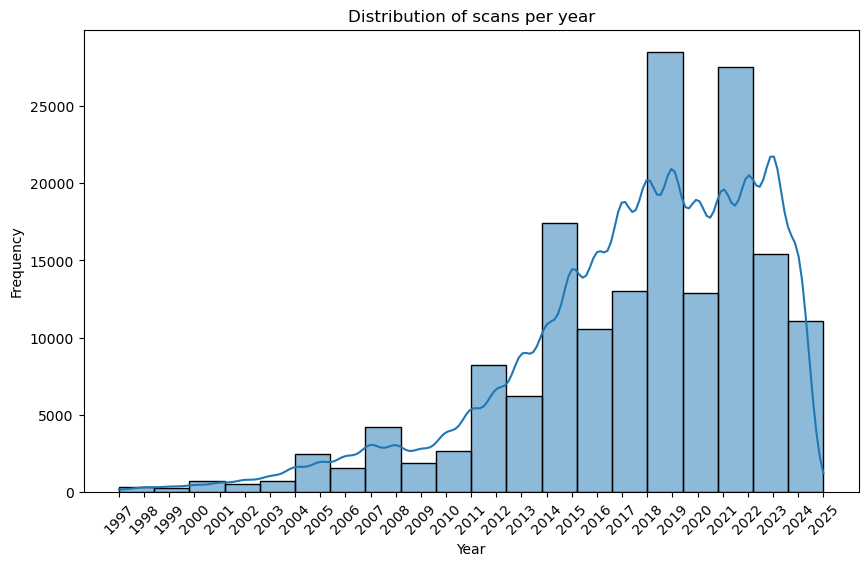

In [20]:
# Sort the years in descending order
sorted_years = sorted(vci_connections_df['year'].unique(), reverse=True)

# Plot distribution
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.histplot(vci_connections_df['year'], kde=True, bins=20)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of scans per year')

# Adjust x-axis ticks: Rotate labels and set in descending order
plt.xticks(sorted_years, rotation=45)

# Show plot
plt.show()

### Examine usage statistics and scanning success rates by product type (Repair / Collision).
Collision shops in general tend to perform more scans during repairs than Repair shops. 

In [21]:
# Get the number of unique shops
unique_shops_count = vci_connections_df['siteId'].nunique()
print(f"Number of unique siteIds: {unique_shops_count}")

# Group by siteId and calculate metrics
shops_df = vci_connections_df.groupby('siteId').apply(lambda group: pd.Series({
    'shop_type': group['product_type'].iloc[0],
    'total_scans': group['result'].count(),              # Total scans by this shop
    'num_success': group['result'].sum(),              # Number of successes (1 = success)
    'vins_success': group.loc[group['result'] == 1, 'vin'].nunique(),  # Unique vins with successful scans
    'vins_failure': group.loc[group['result'] == 0, 'vin'].nunique()   # Unique vins with failed scans
})).reset_index()

# Calculate the number of failures and rates
shops_df['num_failed'] = shops_df['total_scans'] - shops_df['num_success']
shops_df['success_rate'] = (shops_df['num_success'] / shops_df['total_scans']) * 100
shops_df['failure_rate'] = (shops_df['num_failed'] / shops_df['total_scans']) * 100

# Display the statistics for each shop
shops_df.sample(10)

Number of unique siteIds: 1695


,siteId,shop_type,total_scans,num_success,vins_success,vins_failure,num_failed,success_rate,failure_rate
144,94139,REPAIR,4,3,2,1,1,75.000000,25.000000
646,363211,REPAIR,94,76,36,5,18,80.851064,19.148936
526,301911,REPAIR,1,1,1,0,0,100.000000,0.000000
802,445722,COLLISION,109,97,65,4,12,88.990826,11.009174
692,389762,REPAIR,2,2,1,0,0,100.000000,0.000000
1255,670481,REPAIR,13,12,5,1,1,92.307692,7.692308
1138,610285,REPAIR,3,3,3,0,0,100.000000,0.000000
1531,800929,REPAIR,76,75,16,1,1,98.684211,1.315789
113,75824,COLLISION,67,63,34,3,4,94.029851,5.970149
462,261634,COLLISION,82,67,58,5,15,81.707317,18.292683


<Axes: xlabel='total_scans', ylabel='Count'>

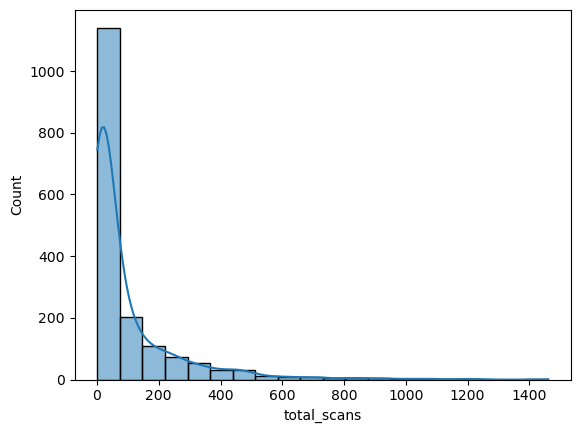

In [22]:
#look at the distribution of number of scans by siteId
sns.histplot(shops_df['total_scans'], kde=True, bins=20)

In [23]:
shops_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
siteId,1695.0,460359.94,250513.91,10799.0,241407.00,467451.00,676217.00,888822.0
total_scans,1695.0,97.95,163.51,1.0,8.00,31.00,109.00,1461.0
num_success,1695.0,86.72,145.64,0.0,7.00,27.00,98.50,1397.0
vins_success,1695.0,49.43,81.80,0.0,4.00,15.00,58.50,753.0
vins_failure,1695.0,3.88,7.15,0.0,0.00,1.00,4.00,113.0
num_failed,1695.0,11.23,25.73,0.0,0.00,3.00,11.00,536.0
success_rate,1695.0,87.59,16.84,0.0,83.06,92.79,100.00,100.0
failure_rate,1695.0,12.41,16.84,0.0,0.00,7.21,16.94,100.0


In [24]:
#find number and percentage of siteIds that only performed one scan
one_scan_shops = shops_df[shops_df['total_scans'] == 1]
num_one_scan_shops = one_scan_shops.shape[0]
percentage_one_scan_shops = (num_one_scan_shops / unique_shops_count) * 100
print(f'Number of shops with only one scan: {num_one_scan_shops}')
print(f'Percentage of shops with only one scan: {percentage_one_scan_shops}')
#repeat for shops with less than 10 scans
less_than_10_scans = shops_df[shops_df['total_scans'] < 10]
num_less_than_10_scans = less_than_10_scans.shape[0]
percentage_less_than_10_scans = (num_less_than_10_scans / unique_shops_count) * 100
print(f'Number of shops with less than 10 scans: {num_less_than_10_scans}')
print(f'Percentage of shops with less than 10 scans: {percentage_less_than_10_scans}')

Number of shops with only one scan: 102
Percentage of shops with only one scan: 6.017699115044247
Number of shops with less than 10 scans: 467
Percentage of shops with less than 10 scans: 27.551622418879056


<Axes: xlabel='success_rate', ylabel='Count'>

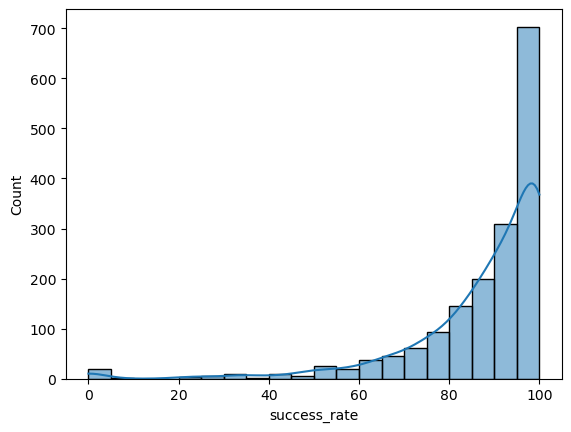

In [25]:
#create distribution plot of success rate
sns.histplot(shops_df['success_rate'], kde=True, bins=20)

### Comparing usage and success rates by customer type
Does one type of customer (repair or collision) have a better connection success rate. Which customer type performs the most scans 

In [26]:
#get breakdown of shops by shop type
shop_type_counts = shops_df['shop_type'].value_counts(normalize=True) * 100 
shop_type_counts

shop_type
COLLISION    48.141593
REPAIR       46.607670
unknown       5.250737
Name: proportion, dtype: float64

In [27]:
baseline_success_rate = shops_df['num_success'].sum() / shops_df['total_scans'].sum() * 100
shop_type_avg = shops_df.groupby('shop_type')['success_rate'].mean()
#print(f'Baseline success rate: {baseline_success_rate:.2f}%')


In [28]:
shops_df.head()

,siteId,shop_type,total_scans,num_success,vins_success,vins_failure,num_failed,success_rate,failure_rate
0,10799,COLLISION,69,62,33,3,7,89.855072,10.144928
1,11077,COLLISION,41,41,27,0,0,100.000000,0.000000
2,12681,REPAIR,135,126,49,5,9,93.333333,6.666667
3,14062,REPAIR,12,12,4,0,0,100.000000,0.000000
4,14492,REPAIR,34,34,27,0,0,100.000000,0.000000


In [30]:

# Look at success / failures by product type
grouped_df = vci_connections_df.groupby(["product_type", "result"]).size().unstack()
grouped_df.head()


result,0,1
product_type,,
COLLISION,14244,108404
REPAIR,3248,25140
unknown,1544,13452


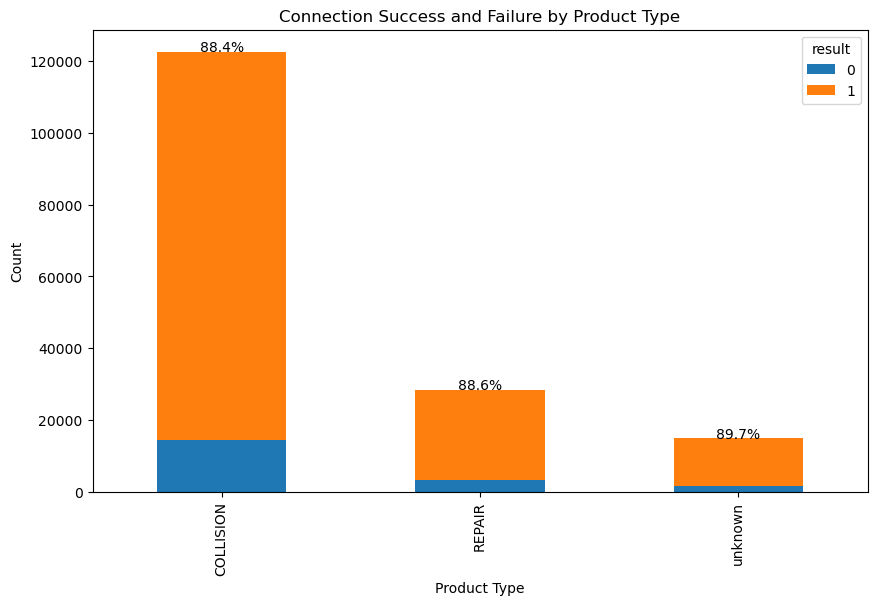

In [31]:

# Look at success / failures by product type
grouped_df = vci_connections_df.groupby(["product_type", "result"]).size().unstack()

ax = grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))
success_rates = grouped_df.div(grouped_df.sum(axis=1), axis=0)[1] * 100  # Convert to percentage

for i, rate in enumerate(success_rates):
    plt.text(i, grouped_df.sum(axis=1)[i] + 5, f"{rate:.1f}%", ha='center')

plt.xlabel('Product Type')
plt.ylabel('Count')
plt.title('Connection Success and Failure by Product Type')
plt.show()

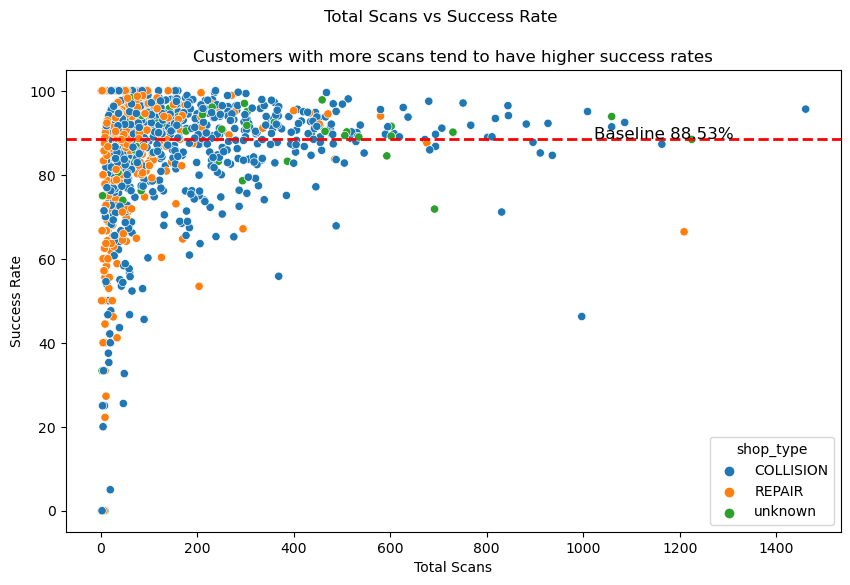

In [36]:
 #do higher number of scans correlate with higher success rates?
# Create a scatter plot of total scans vs success rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_scans', y='success_rate', hue='shop_type', data=shops_df)
plt.xlabel('Total Scans')
plt.ylabel('Success Rate')
plt.suptitle('Total Scans vs Success Rate')
# Add baseline success rate as a horizontal line
plt.axhline(y=baseline_success_rate, color='red', linestyle='--', linewidth=2, label=f'Baseline')
plt.title('Customers with more scans tend to have higher success rates')
plt.text(
    x=shops_df['total_scans'].max() * 0.70,  
    y=baseline_success_rate + 0.01,   
    s=f"Baseline {baseline_success_rate:.2f}%", 
    color="black",
    fontsize=12
)

plt.show()

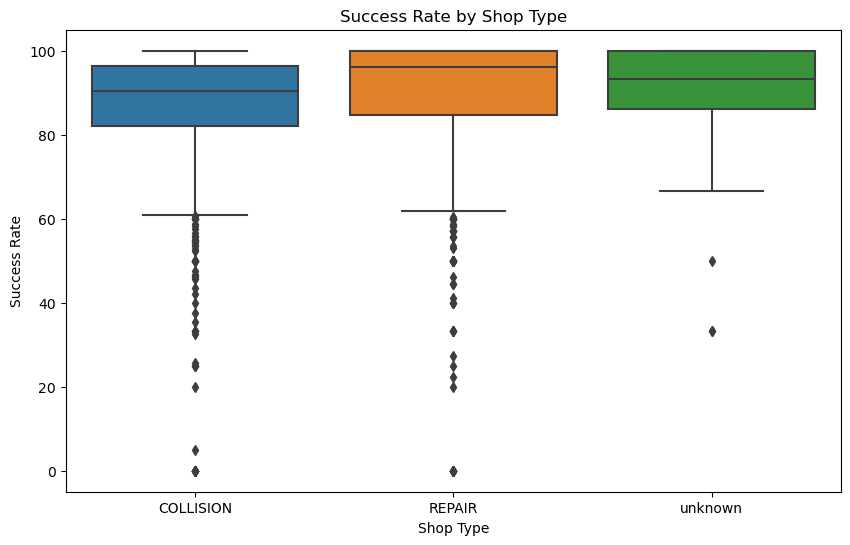

In [29]:
#Which type of shop has the highest success rate?
plt.figure(figsize=(10, 6))
sns.boxplot(x='shop_type', y='success_rate', data=shops_df)
plt.xlabel('Shop Type')
plt.ylabel('Success Rate')
plt.title('Success Rate by Shop Type')
plt.show()

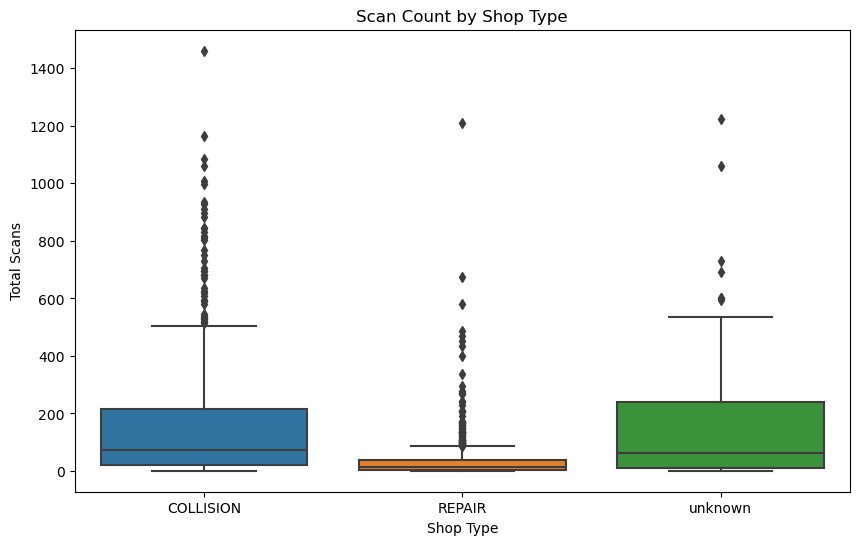

In [30]:
#Which type of shop does the most scans? 
plt.figure(figsize=(10, 6))
sns.boxplot(x='shop_type', y='total_scans', data=shops_df)
plt.xlabel('Shop Type')
plt.ylabel('Total Scans')
plt.title('Scan Count by Shop Type')
plt.show()

### Look at all VINs that do not have any successful scans - these are likely tool issues
Find vehicles and systems that the scantool has persistant connection errors. This list can be supplied to the scantool hardware supplier and addressed first!

In [43]:
#create dataframe of failed scans for vins that have no successful scans
vin_max = vci_connections_df.groupby('vin')['result'].max()

# Select VINs where the max result is 0 (i.e., all records have a result of 0)
unique_vins = vin_max[vin_max == 0].index.tolist()
#len(unique_vins)
#get records where vin is in unique_vins list
all_failed_vins_df = vci_connections_df[vci_connections_df['vin'].isin(unique_vins)]
print('Information for vins with only failed scans')
print_unique_attributes(all_failed_vins_df)


Information for vins with only failed scans
Number of entries: 5945
Number of unique years: 29
Number of unique makes: 40
Number of unique models: 269
Number of unique vins: 1587
Number of unique veh_descs: 1431


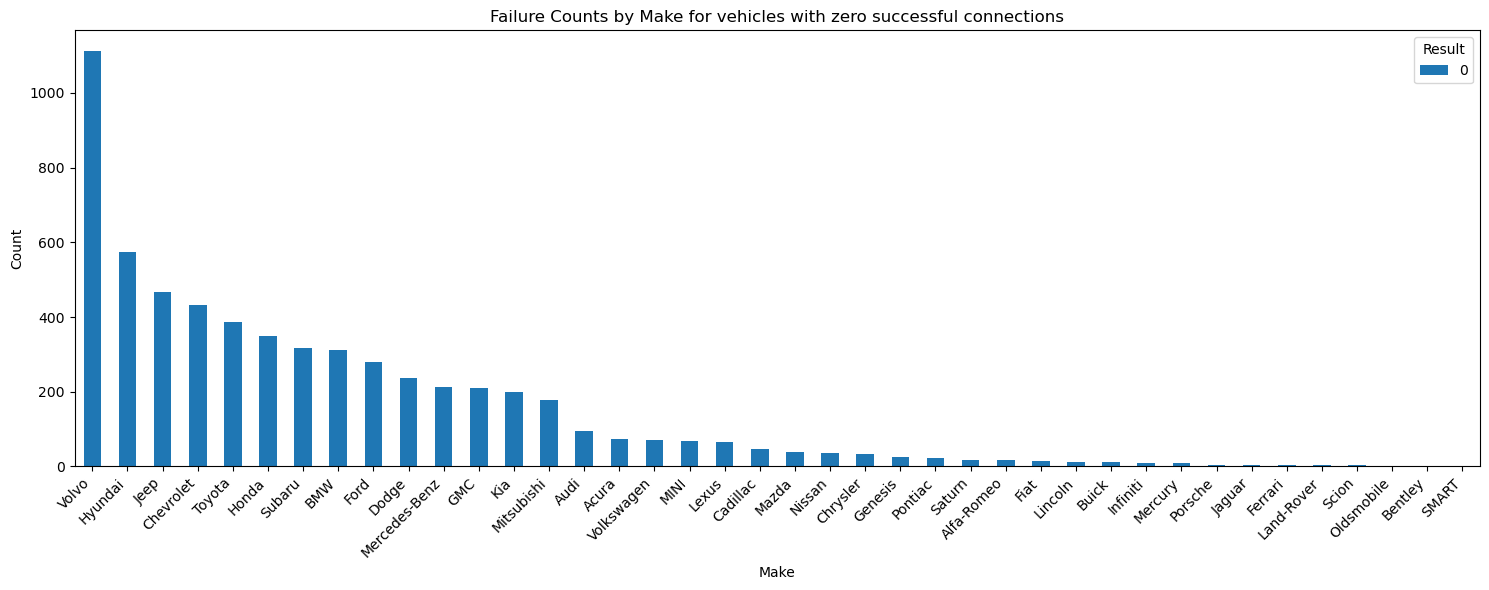

In [44]:
#create barplot of success and failure counts for connections by make
df = all_failed_vins_df.groupby(['make', 'result']).size().unstack(fill_value=0).sort_values(by=0, ascending=False)
df.plot(kind='bar', stacked=False, figsize=(15, 6))
plt.title('Failure Counts by Make for vehicles with zero successful connections')
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Result')
plt.tight_layout()
plt.show()
#makes_df.head()

In [45]:
#find how many records for each vin in all_failed_vins_df
vin_counts = all_failed_vins_df['vin'].value_counts()
vin_counts.describe()

count    1587.000000
mean        3.746062
std         3.674206
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        39.000000
Name: count, dtype: float64

In [48]:
#Get the frequency of failed scans for shops that have scanned vehicles with no successful connections
shops = all_failed_vins_df['siteId'].value_counts()
shops.describe()

count    686.000000
mean       8.666181
std       10.938618
min        1.000000
25%        2.000000
50%        5.000000
75%       11.000000
max      114.000000
Name: count, dtype: float64

In [49]:
#For each VIN in all_failed_vins_df, vehicle description, total_failures and num_shops that scanned that vin:
vin_summary_df = all_failed_vins_df.groupby('vin').agg(
    veh_desc=('veh_desc', 'first'),         # Assuming veh_desc is the same for each VIN
    total_failures=('vin', 'size'),         # Count of records (failures) per VIN
    num_shops=('siteId', 'nunique')         # Unique shop count per VIN
).reset_index()

print(f'Number of unique VINs with all failures: {vin_summary_df.shape[0]}')

one_scan_summary_df = vin_summary_df[vin_summary_df['total_failures'] == 1]
print(f'Number of VINs with single failure and no successful scans: {one_scan_summary_df.shape[0]}')

one_shop_summary_df = vin_summary_df[vin_summary_df['num_shops'] == 1]
print(f'Number of VINs with failures at only one shop: {one_shop_summary_df.shape[0]}')

multi_shop_summary_df = vin_summary_df[vin_summary_df['num_shops'] > 1]
print(f'Number of VINs with failures at multiple shops: {multi_shop_summary_df.shape[0]}')
multi_shop_summary_df.to_excel('../Data/MultiShopFailures.xlsx', sheet_name='multi_shop_failures', index=False)
multi_shop_summary_df.head(5)

Number of unique VINs with all failures: 1587
Number of VINs with single failure and no successful scans: 389
Number of VINs with failures at only one shop: 1533
Number of VINs with failures at multiple shops: 54


,vin,veh_desc,total_failures,num_shops
40,1C4RJFAG6NC,2022 Jeep Grand Cherokee Enhanced Powertrain,10,2
46,1C4RJFBG8NC,2022 Jeep Grand Cherokee Enhanced Powertrain,16,2
54,1C4RJKBG9M8,2021 Jeep Grand Cherokee Enhanced Powertrain,17,3
55,1C4RJKBGXM8,2021 Jeep Grand Cherokee Enhanced Powertrain,12,2
57,1C4RJKDG2M8,2021 Jeep Grand Cherokee Enhanced Powertrain,6,2


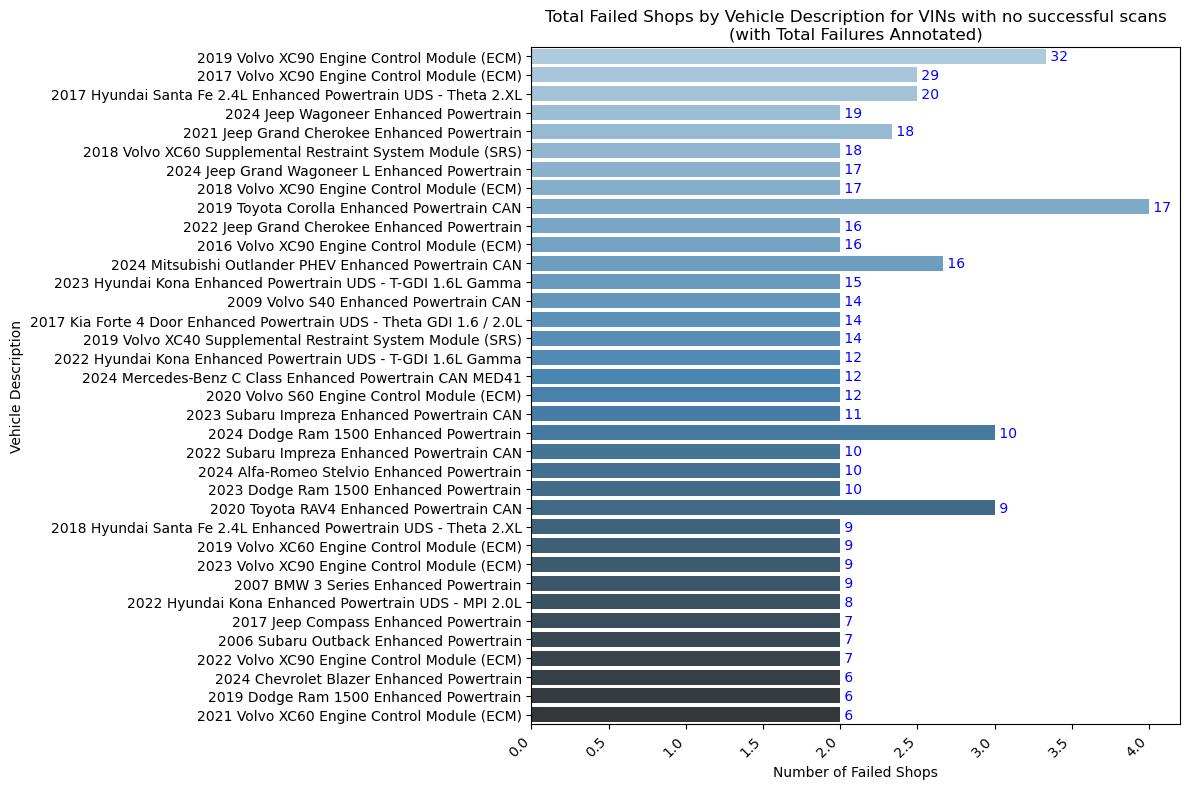

In [55]:
#create barplot of total shop failures for each vehicle description in multi_shop_summary_df

multi_shop_summary_df = multi_shop_summary_df.sort_values('total_failures', ascending=False)

# Create a bar chart with veh_desc on the x-axis and total_failed_shops as the y-axis
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='num_shops', y='veh_desc', data=multi_shop_summary_df, palette='Blues_d', ci=None)

# Annotate each bar with the total_failures value
# Annotate each bar with the total_failures value
for p, (_, row) in zip(bar_plot.patches, multi_shop_summary_df.iterrows()):
    # p.get_width() gives the length of the bar
    x = p.get_width()
    y = p.get_y() + p.get_height() / 2.
    bar_plot.text(x, y, f" {row.total_failures}", ha='left', va='center', color='blue', fontsize=10)

plt.xlabel("Number of Failed Shops")
plt.ylabel("Vehicle Description")
plt.title("Total Failed Shops by Vehicle Description for VINs with no successful scans\n(with Total Failures Annotated)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [37]:
#for each shop count number of failed vins
failed_shops_df = all_failed_vins_df.groupby('siteId')['vin'].nunique().reset_index(name='count')
#For each shop count total number of failed scans
failed_shops_df['total_failures'] = all_failed_vins_df.groupby('siteId')['result'].count().values
failed_shops_df = failed_shops_df.sort_values(by='count', ascending=False)

#find siteId from shops_df and add success rate and shop type to failed_shops_df
success_rate_map = shops_df.set_index('siteId')['success_rate'].to_dict()
shop_type_map = shops_df.set_index('siteId')['shop_type'].to_dict()

failed_shops_df['success_rate'] = failed_shops_df['siteId'].map(success_rate_map)
failed_shops_df['shop_type'] = failed_shops_df['siteId'].map(shop_type_map)

#sort by success rate lowest to highest
failed_shops_df = failed_shops_df.sort_values(by='success_rate')

failed_shops_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
siteId,686.0,465789.31,247776.50,12681.0,250364.75,468830.5,680078.75,888594.00
count,686.0,2.41,2.36,1.0,1.00,2.0,3.00,23.00
total_failures,686.0,8.67,10.94,1.0,2.00,5.0,11.00,114.00
success_rate,686.0,81.14,17.59,0.0,77.27,86.7,91.83,99.65


## Investigate metrics per unique VIN

In [38]:
# Get the number of unique VINs
unique_vins_count = vci_connections_df['vin'].nunique()
#print(f"Number of unique VINs at site {site_id_value}: {unique_vins_count}")
print(f"Number of unique VINs: {unique_vins_count}")

# Group by VIN and calculate metrics
vin_stats_df = vci_connections_df.groupby('vin').apply(lambda group: pd.Series({
    'total': group['result'].count(),              # Total scans per VIN
    'num_success': group['result'].sum(),              # Number of successes (assuming 1 = success)
    'shops_success': group.loc[group['result'] == 1, 'siteId'].nunique(),  # Unique shops with result = 1
    'shops_failure': group.loc[group['result'] == 0, 'siteId'].nunique()   # Unique shops with result = 0
})).reset_index()

# Calculate the number of failures and rates
vin_stats_df['num_failed'] = vin_stats_df['total'] - vin_stats_df['num_success']
vin_stats_df['success_rate'] = (vin_stats_df['num_success'] / vin_stats_df['total']) * 100
vin_stats_df['failure_rate'] = (vin_stats_df['num_failed'] / vin_stats_df['total']) * 100

# Display the statistics for each VIN
vin_stats_df.sample(5)

Number of unique VINs: 62091


,vin,total,num_success,shops_success,shops_failure,num_failed,success_rate,failure_rate
60501,WDDHF8BB8GB,1,1,1,0,0,100.0,0.0
24005,2HGFB2E42DH,2,2,1,0,0,100.0,0.0
3273,1C6RR7LG6DS,3,3,1,0,0,100.0,0.0
856,1C4AJWAG9CL,1,1,1,0,0,100.0,0.0
5252,1FM5K7D8XFG,1,1,1,0,0,100.0,0.0


In [39]:
vin_stats_df.describe()

,total,num_success,shops_success,shops_failure,num_failed,success_rate,failure_rate
count,62091.000000,62091.000000,62091.000000,62091.000000,62091.000000,62091.000000,62091.000000
mean,2.674011,2.367428,1.349294,0.106038,0.306582,94.103976,5.896024
std,2.560967,2.133805,0.906576,0.331467,1.378083,20.103465,20.103465
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,100.000000,0.000000
50%,2.000000,2.000000,1.000000,0.000000,0.000000,100.000000,0.000000
75%,3.000000,3.000000,1.000000,0.000000,0.000000,100.000000,0.000000
max,43.000000,42.000000,15.000000,5.000000,39.000000,100.000000,100.000000


### Examine the Impact of Different Features on Success and Failure Rates

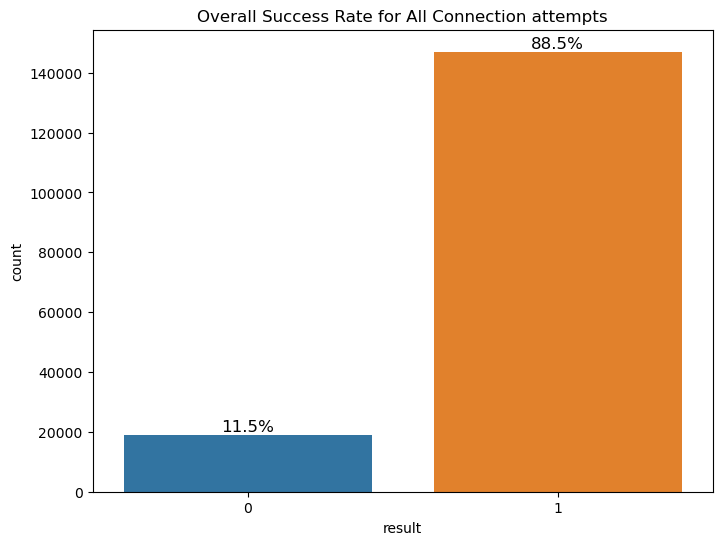

In [40]:
#create plot of overall success rate for all connections
plot_success_failure_rate(vci_connections_df, 'Overall Success Rate for All Connection attempts')

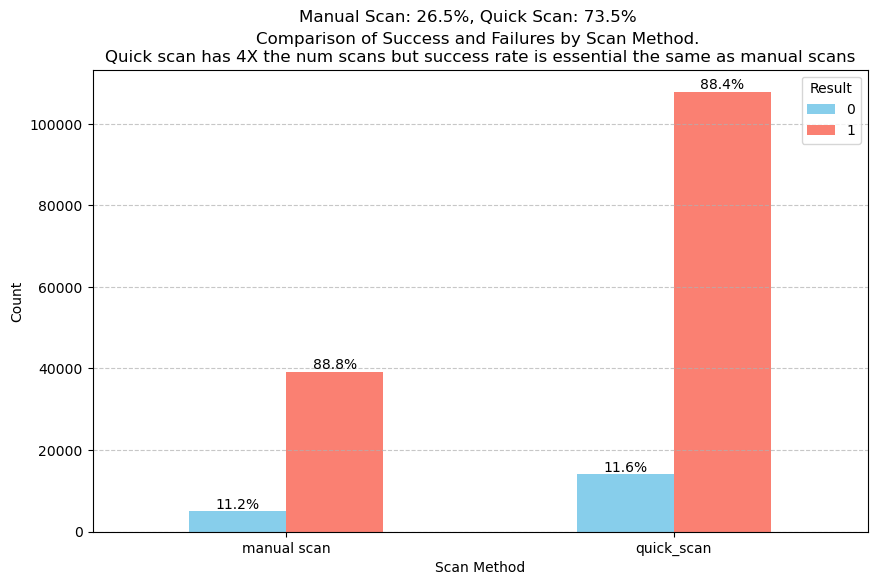

In [41]:
#compare the connection success rate based on connection method
scan_method_df = pd.crosstab(vci_connections_df['scan_method'], vci_connections_df['result'])


percentages = scan_method_df.div(scan_method_df.sum(axis=1), axis=0) * 100
ax = scan_method_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Comparison of Success and Failures by Scan Method. \nQuick scan has 4X the num scans but success rate is essential the same as manual scans')
plt.xlabel('Scan Method')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Result')

#add annotation of manual scan vs quick_scan total percentage
total_scans = vci_connections_df.shape[0]
total_manual = vci_connections_df[vci_connections_df['scan_method'] == 'manual scan'].shape[0]
total_quick_scan = vci_connections_df[vci_connections_df['scan_method'] == 'quick_scan'].shape[0]

manual_percentage = (total_manual / total_scans) * 100
quick_scan_percentage = (total_quick_scan / total_scans) * 100
# Annotate percentages as subtitle
plt.suptitle(f'Manual Scan: {manual_percentage:.1f}%, Quick Scan: {quick_scan_percentage:.1f}%', fontsize=12)

# Annotate percentages on the bars
for bar_group, percentage_group in zip(ax.containers, percentages.T.iterrows()):
    for bar, percentage in zip(bar_group, percentage_group[1]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate
            bar.get_height() + 0.5,  # Y-coordinate
            f'{percentage:.1f}%',  # Percentage text
            ha='center', va='bottom', fontsize=10  # Align text
        )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

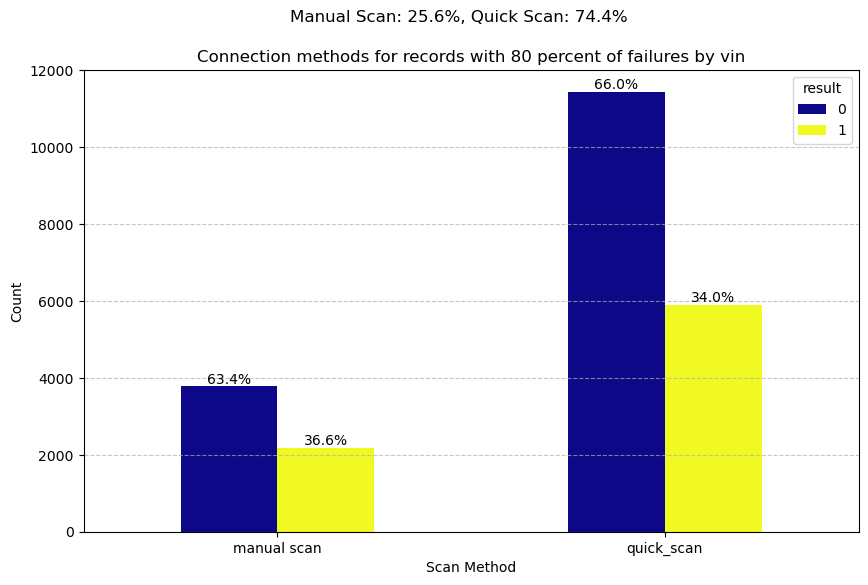

In [42]:
failed_vins_df_80 = vci_connections_df[vci_connections_df['vin'].isin(top_failed_attributes_80['vin'])]
#compare success failure rate based on connection type for dataframe that has 80% of failures
scan_method_df = pd.crosstab(failed_vins_df_80['scan_method'], failed_vins_df_80['result'])


percentages = scan_method_df.div(scan_method_df.sum(axis=1), axis=0) * 100

ax = scan_method_df.plot(kind='bar', figsize=(10, 6), colormap='plasma')
plt.title('Connection methods for records with 80 percent of failures by vin')
plt.xlabel('Scan Method')
plt.ylabel('Count')
plt.xticks(rotation=0)

#add annotation of manual scan vs quick_scan total percentage
total_scans = failed_vins_df_80.shape[0]
total_manual = failed_vins_df_80[failed_vins_df_80['scan_method'] == 'manual scan'].shape[0]
total_quick_scan = failed_vins_df_80[failed_vins_df_80['scan_method'] == 'quick_scan'].shape[0]

manual_percentage = (total_manual / total_scans) * 100
quick_scan_percentage = (total_quick_scan / total_scans) * 100
# Annotate percentages as subtitle
plt.suptitle(f'Manual Scan: {manual_percentage:.1f}%, Quick Scan: {quick_scan_percentage:.1f}%', fontsize=12)

# Annotate percentages on the bars
for bar_group, percentage_group in zip(ax.containers, percentages.T.iterrows()):
    for bar, percentage in zip(bar_group, percentage_group[1]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate
            bar.get_height() + 0.5,  # Y-coordinate
            f'{percentage:.1f}%',  # Percentage text
            ha='center', va='bottom', fontsize=10  # Align text
        )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [43]:
#compute percentage of total scans for each scan method
scan_method_df['total'] = scan_method_df[0] + scan_method_df[1]
overall_total = scan_method_df['total'].sum()
scan_method_df['percentage'] = (scan_method_df['total'] / overall_total) * 100
scan_method_df.head()

result,0,1,total,percentage
scan_method,,,,
manual scan,3782,2187,5969,25.596055
quick_scan,11446,5905,17351,74.403945


In [44]:
#Look at number of unique vehicle descriptions
summary_df = vci_connections_df.groupby('veh_desc')['result'].agg(total_attempts='count', total_failures=lambda x: (x == 0).sum()).reset_index()

# Calculate the failure rate
summary_df['failure_rate'] = summary_df['total_failures'] / summary_df['total_attempts'] * 100

# Sort by failure rate in descending order
#sorted_summary = summary_df.sort_values(by='failure_rate', ascending=False)

# Display the results
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10276 entries, 0 to 10275
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   veh_desc        10276 non-null  object 
 1   total_attempts  10276 non-null  int64  
 2   total_failures  10276 non-null  int64  
 3   failure_rate    10276 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 321.3+ KB


### Look at distribution of battery voltage and see if it affects connection success rate

Text(0.5, 1.0, 'Distribution of Battery Voltage')

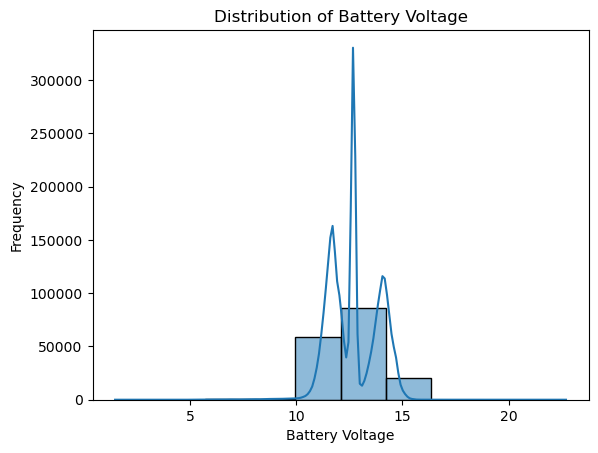

In [45]:
#distribution plot of the battery voltage
batt_voltage_df = vci_connections_df[vci_connections_df['batt_voltage'] > 0]
sns.histplot(batt_voltage_df['batt_voltage'], kde=True, bins=10)

# Add labels and title
plt.xlabel('Battery Voltage')
plt.ylabel('Frequency')
plt.title('Distribution of Battery Voltage')

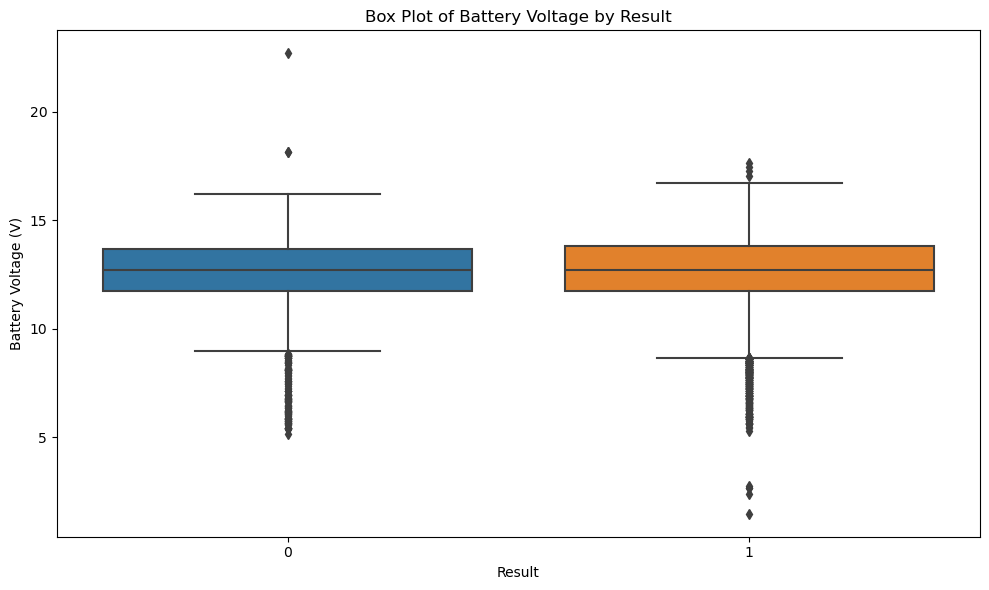

In [46]:
#Look at box plot of battery voltage by result
batt_voltage_df = vci_connections_df[vci_connections_df['batt_voltage'] > 0]
plt.figure(figsize=(10, 6))
sns.boxplot(data=batt_voltage_df, x='result', y='batt_voltage')
plt.title('Box Plot of Battery Voltage by Result')
plt.xlabel('Result')
plt.ylabel('Battery Voltage (V)')
plt.tight_layout()
plt.show()

## Investigate vehicle attributes make, model, year and system_category
Determine which makes / models have the most scans. Which ones have highest failure rates. Does success rate change by model year? 

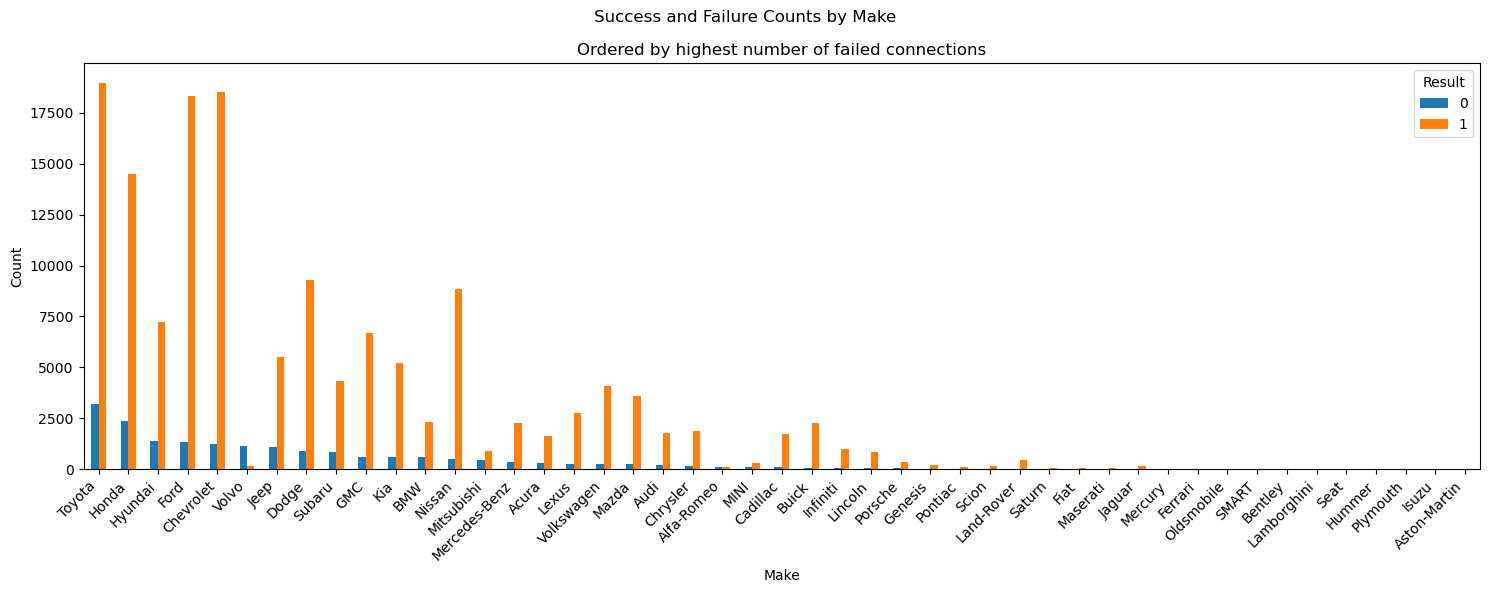

In [47]:
#create barplot of success and failure counts for connections by make
make_results_df = vci_connections_df.groupby(['make', 'result']).size().unstack(fill_value=0).sort_values(by=0, ascending=False)
make_results_df.plot(kind='bar', stacked=False, figsize=(15, 6))
plt.suptitle('Success and Failure Counts by Make')
plt.title('Ordered by highest number of failed connections')
plt.xlabel('Make')
overall_success_rate = calculate_success_rate(vci_connections_df)
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Result')
plt.tight_layout()
plt.show()

In [48]:
make_results_df.reset_index(inplace=True)
make_results_df.columns

Index(['make', 0, 1], dtype='object', name='result')

In [129]:
make_results_df['success_rate'] = (make_results_df[1] /(make_results_df[1] + make_results_df[0])) * 100
make_results_df['total'] = (make_results_df[1] + make_results_df[0])
make_results_df['failure_rate'] = 100 - make_results_df['success_rate']
make_results_df.head(12)

result,index,make,0,1,success_rate,total,failure_rate,cumulative_percentage
0,0,Toyota,3209,18969,85.530706,22178,14.469294,13.357666
4,4,Chevrolet,1266,18501,93.595386,19767,6.404614,52.461574
3,3,Ford,1325,18330,93.258713,19655,6.741287,40.556037
1,1,Honda,2397,14504,85.817407,16901,14.182593,23.537029
7,7,Dodge,895,9299,91.220326,10194,8.779674,63.388383
12,12,Nissan,496,8834,94.683816,9330,5.316184,81.794473
2,2,Hyundai,1396,7206,83.771216,8602,16.228784,28.717958
9,9,GMC,614,6685,91.587889,7299,8.412111,70.901393
6,6,Jeep,1118,5489,83.078553,6607,16.921447,57.248603
10,10,Kia,614,5230,89.493498,5844,10.506502,74.421196


In [ ]:
#fig.update_layout(margin=dict(t=100))
#make_results_df.reset_index(inplace=True)
fig = px.scatter(
    make_results_df,
    x=1,       # Successful scans
    y=0,        # Failed scans
    hover_name='make',       # On hover, show the make
    hover_data=['total', 'success_rate', 'failure_rate'],  # Additional info
    title="Success vs. Failed Scans for all Makes<br><sub>Toyota, Chevrolet, Ford and Honda dominate other makes in number of scans</sub>",
    color='make',
    labels={'1': 'Successful Scans', '0': 'Failed Scans'}
)

fig.update_traces(marker=dict(size=12), textposition='top center')
fig.show()

In [149]:
df_top12 = make_results_df.sort_values(by='total', ascending=False).head(12)
#df_top12.reset_index(inplace=True)

fig = px.scatter(
    df_top12,
    x=1,       # Successful scans
    y=0,        # Failed scans
    hover_name='make',       # On hover, show the make
    hover_data=['total', 'success_rate', 'failure_rate'],  # Additional info
    title="Success and failures for Top 12 Makes<br><sub>Toyota, Chevrolet, Ford and Honda dominate other makes in number of scans</sub>",
    color='make',
    labels={'1': 'Successful Scans', '0': 'Failed Scans'}
)

fig.update_traces(marker=dict(size=12), textposition='top center')
fig.show()

In [52]:
#Look at success rate by vehicle make
make_results_df['cumulative_percentage'] = make_results_df['total'].cumsum() / make_results_df['total'].sum() * 100
make_results_df = make_results_df.sort_values(by='total', ascending=False)
make_results_df.head(12)

result,index,make,0,1,success_rate,total,failure_rate,cumulative_percentage
0,0,Toyota,3209,18969,85.530706,22178,14.469294,13.357666
4,4,Chevrolet,1266,18501,93.595386,19767,6.404614,52.461574
3,3,Ford,1325,18330,93.258713,19655,6.741287,40.556037
1,1,Honda,2397,14504,85.817407,16901,14.182593,23.537029
7,7,Dodge,895,9299,91.220326,10194,8.779674,63.388383
12,12,Nissan,496,8834,94.683816,9330,5.316184,81.794473
2,2,Hyundai,1396,7206,83.771216,8602,16.228784,28.717958
9,9,GMC,614,6685,91.587889,7299,8.412111,70.901393
6,6,Jeep,1118,5489,83.078553,6607,16.921447,57.248603
10,10,Kia,614,5230,89.493498,5844,10.506502,74.421196


In [53]:
#Investigate scanning success rate based on VCI version
makes2_df = vci_connections_df[['make', 'vci_version', 'result']]
makes2_df.sample(5)

,make,vci_version,result
53711,Chevrolet,22.3.2439.2,1
35996,Ford,22.3.2439.2,1
67882,Hyundai,22.2.2424.1,1
1553,Toyota,22.3.2439.2,1
144558,Nissan,22.3.2439.2,1


In [54]:
failures_by_vci_ver_df = makes2_df[makes2_df['result'] == 0].groupby(['make', 'vci_version']).size()
total_by_vci_ver_df = makes2_df.groupby(['make', 'vci_version']).size()
failure_percentage_df = (failures_by_vci_ver_df / total_by_vci_ver_df * 100).reset_index(name='failure_percentage')
#remove NaN values
failure_percentage_df = failure_percentage_df.dropna()
#failure_percentage_df.sample(20)

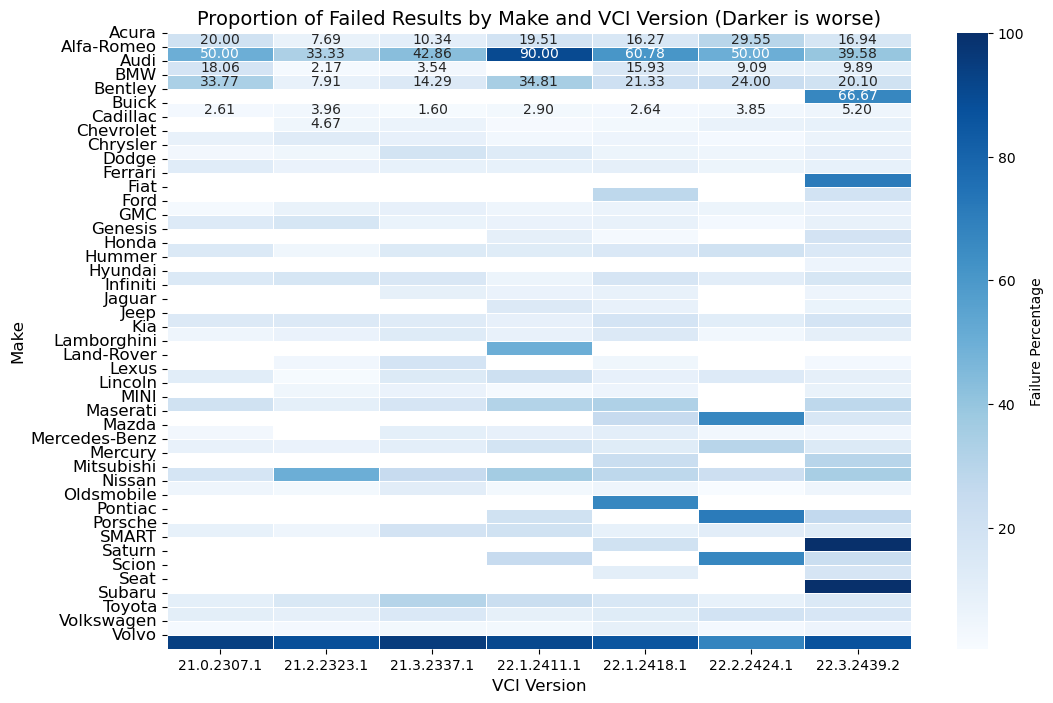

In [152]:
heatmap_data = failure_percentage_df.pivot(index="make", columns="vci_version", values="failure_percentage")

heatmap_data = heatmap_data.sort_index(ascending=True)

fig_height = max(8, len(heatmap_data) * 0.5) 

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    heatmap_data, 
    annot=True,          
    cmap="Blues",       
    fmt=".2f",          
    linewidths=0.5,      
    cbar_kws={'label': 'Failure Percentage'}   
)

ax.set_yticks(range(len(heatmap_data)))
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=12)


plt.title("Proportion of Failed Results by Make and VCI Version (Darker is worse)", fontsize=14)
plt.xlabel("VCI Version", fontsize=12)
plt.ylabel("Make", fontsize=12)

# Show the plot
plt.savefig("../Images/heatmap_failures_by_vci_version.png", dpi=300, bbox_inches="tight")
plt.show()

In [56]:
years_df = vci_connections_df.groupby(['year', 'result']).size().unstack()
years_df['success_rate'] = years_df[1] / (years_df[1] + years_df[0]) * 100
years_df['failure_rate'] = years_df[0] / (years_df[1] + years_df[0]) * 100
years_df.sample(5)
years_df.head()

result,0,1,success_rate,failure_rate
year,,,,
1997,27,68,71.578947,28.421053
1998,19,185,90.686275,9.313725
1999,40,190,82.608696,17.391304
2000,71,228,76.254181,23.745819
2001,77,329,81.034483,18.965517


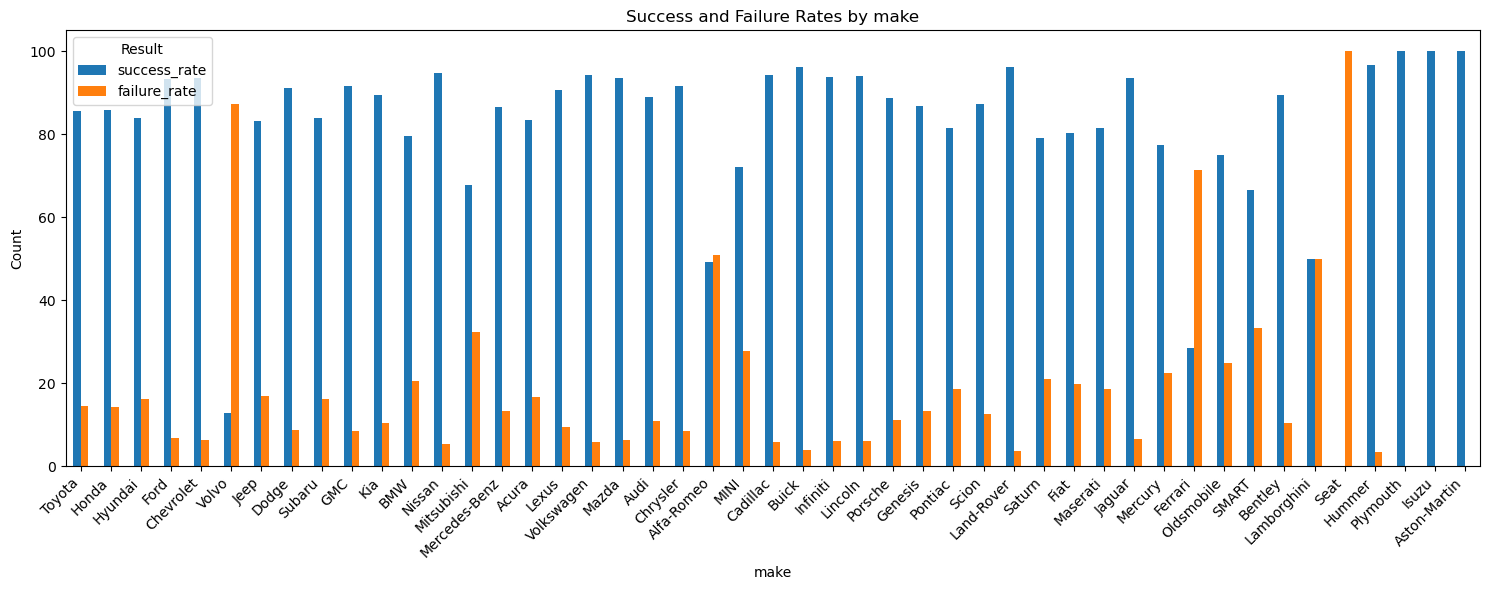

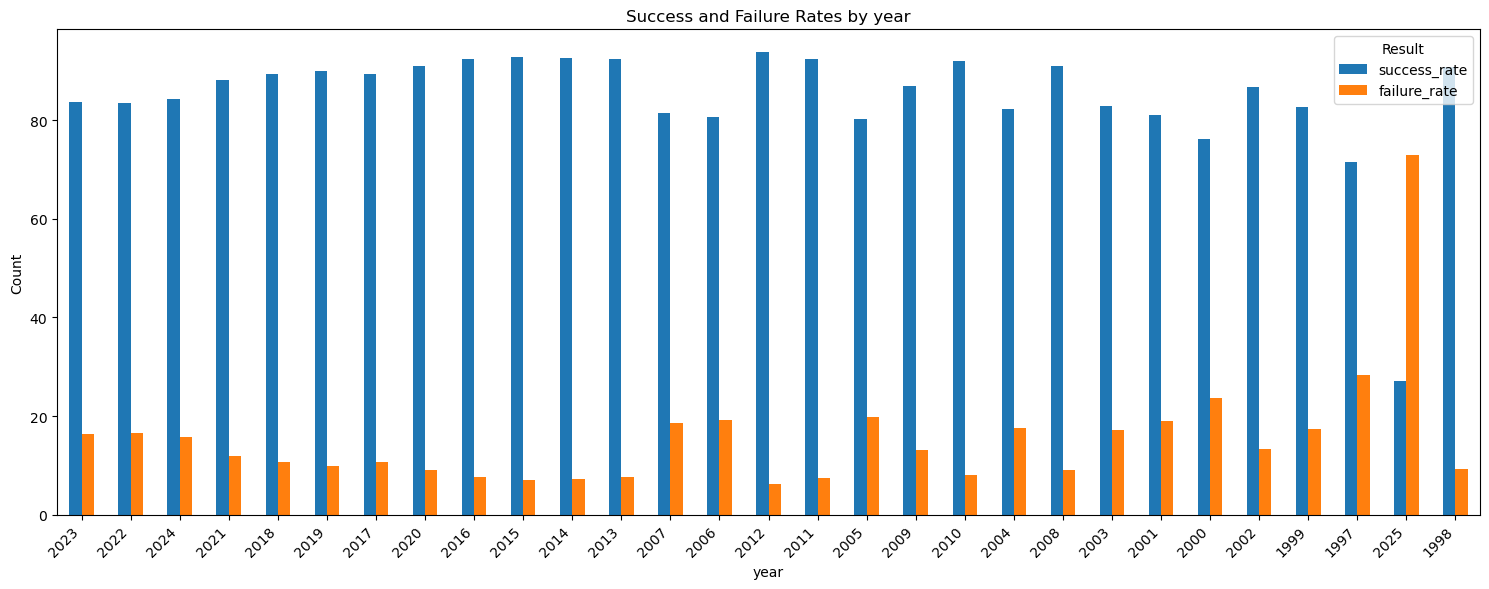

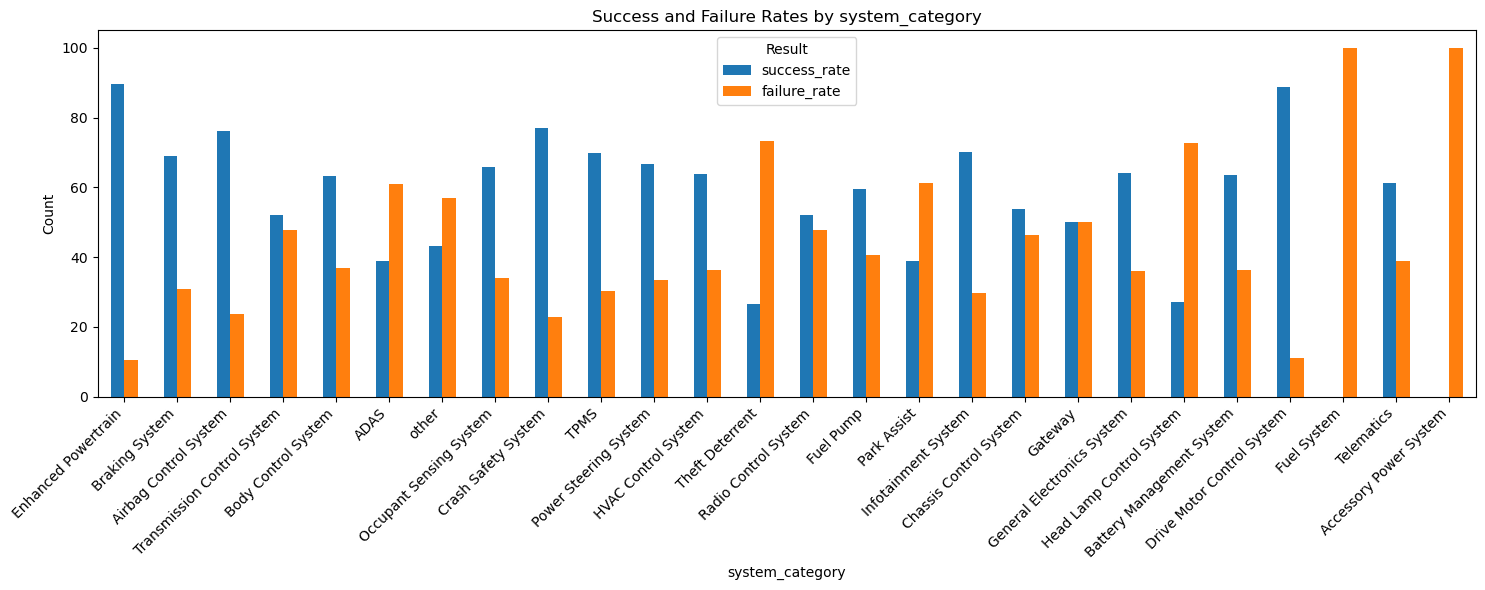

In [57]:
veh_attributes = ['make', 'year', 'system_category']
for attribute in veh_attributes:
    grouped_data = vci_connections_df.groupby([attribute, 'result']).size().unstack(fill_value=0).sort_values(by=0, ascending=False)
    grouped_data['success_rate'] = grouped_data[1] / (grouped_data[1] + grouped_data[0]) * 100
    grouped_data['failure_rate'] = grouped_data[0] / (grouped_data[1] + grouped_data[0]) * 100
    grouped_data = grouped_data[['success_rate', 'failure_rate']]
    grouped_data.plot(kind='bar', stacked=False, figsize=(15, 6))
    plt.title(f'Success and Failure Rates by {attribute}')
    plt.xlabel(attribute)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Result')
    plt.tight_layout()
    plt.show()

In [58]:
systems_df = vci_connections_df.groupby(['system_category', 'result']).size().unstack(fill_value=0).sort_values(by=0, ascending=False)
systems_df.head()

result,0,1
system_category,,
Enhanced Powertrain,16518,142020
Braking System,711,1586
Airbag Control System,410,1315
Transmission Control System,328,358
Body Control System,166,285


In [59]:
#Show heatmap with counts
def create_heat_map(data_frame, x, y, title):
    # Create a contingency table
    contingency_table = pd.crosstab(data_frame[y], data_frame[x])

    # Plot the heatmap of the contingency table
    plt.figure(figsize=(12, 6))
    sns.heatmap(contingency_table, annot=True, cmap="Reds", fmt="d", cbar=False)

    # Add labels and title
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [60]:
#show heatmap of success rate for pass in features. Assumes diag_usage_df is already defined
def create_contingency_table_results(df, x, y, title):
    success_rate_table = df[[y, x, 'result']]
    success_rate_table = success_rate_table.groupby([y, x])['result'].mean().unstack()

    # Display the resulting table
    plt.figure(figsize=(10, 6))  # Set figure size
    sns.heatmap(success_rate_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Success Rate'})

    # Add labels and title
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)

    # Show the plot
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

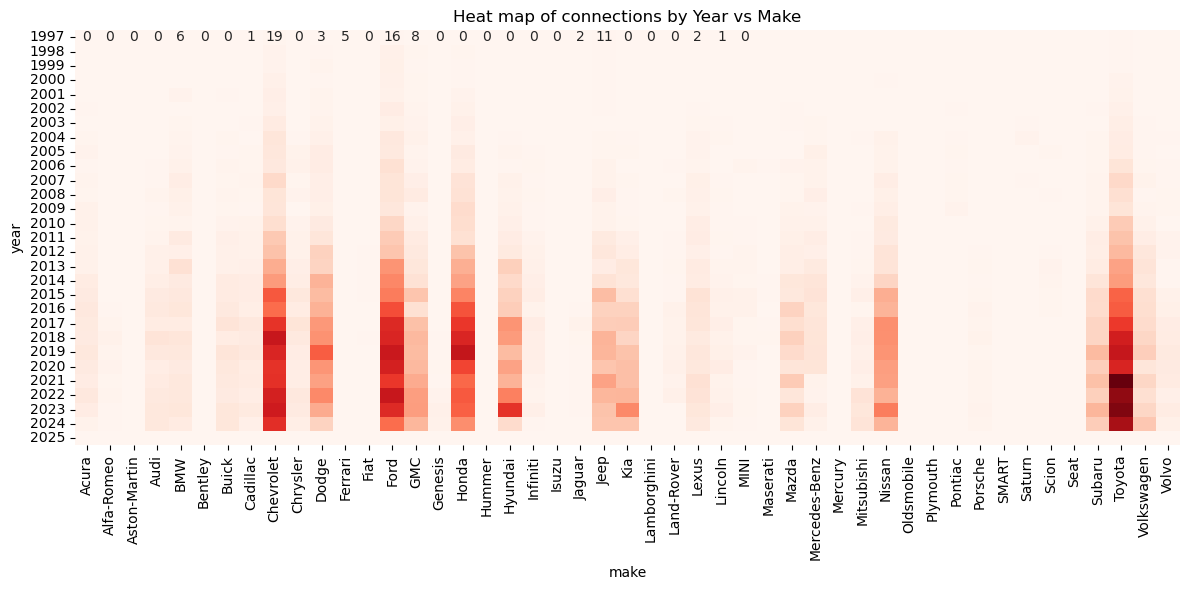

In [61]:
create_heat_map(vci_connections_df, 'make', 'year', 'Heat map of connections by Year vs Make')

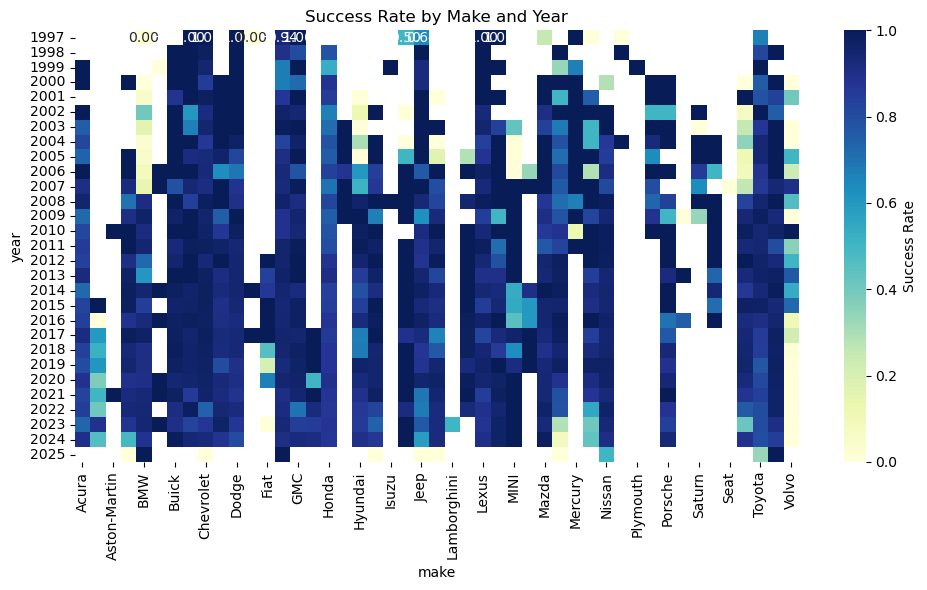

In [62]:
create_contingency_table_results(vci_connections_df, 'make', 'year', 'Success Rate by Make and Year')

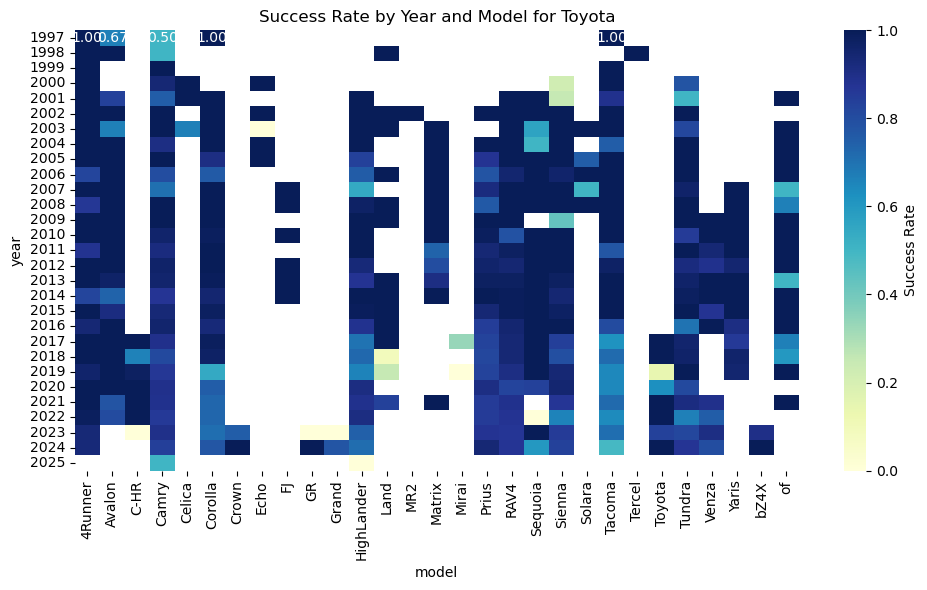

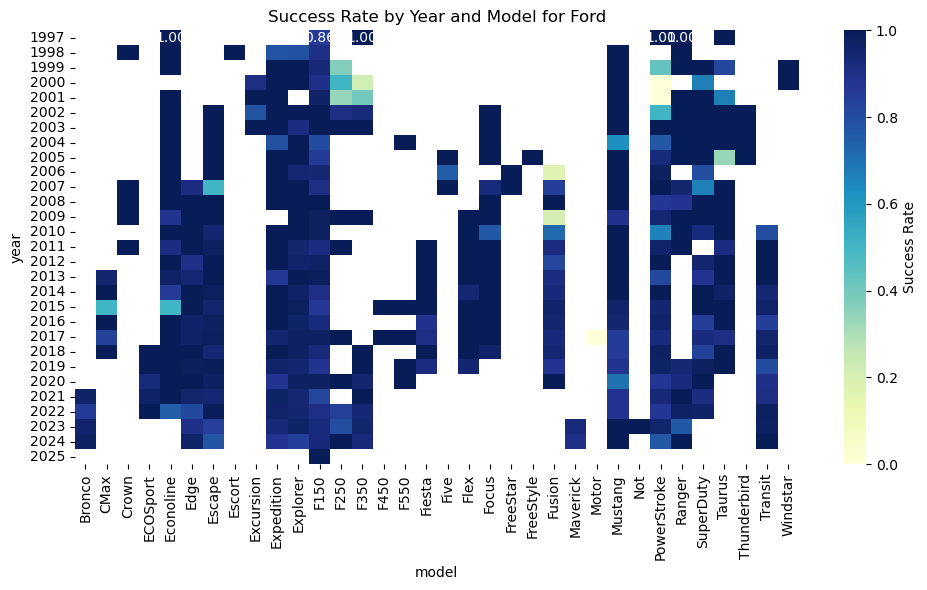

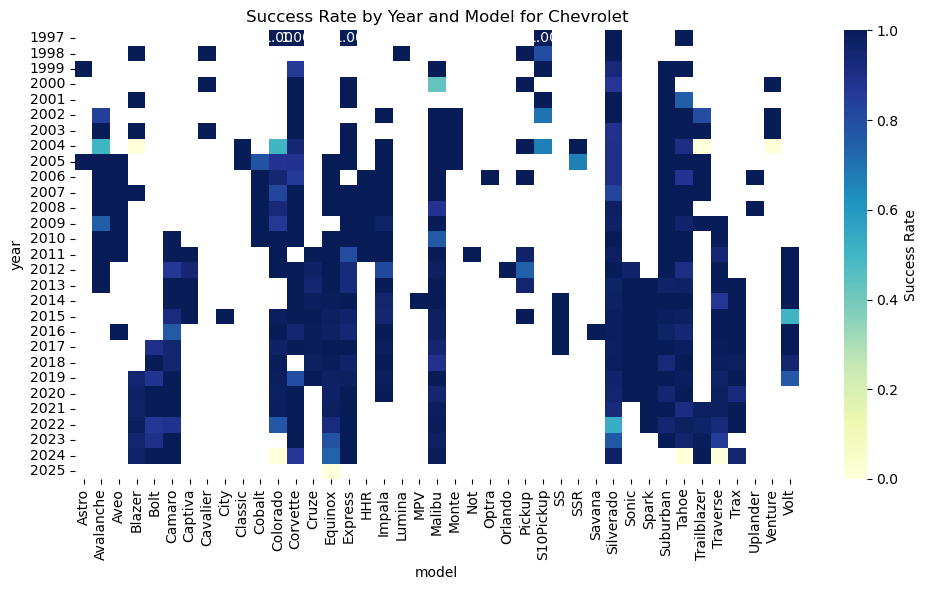

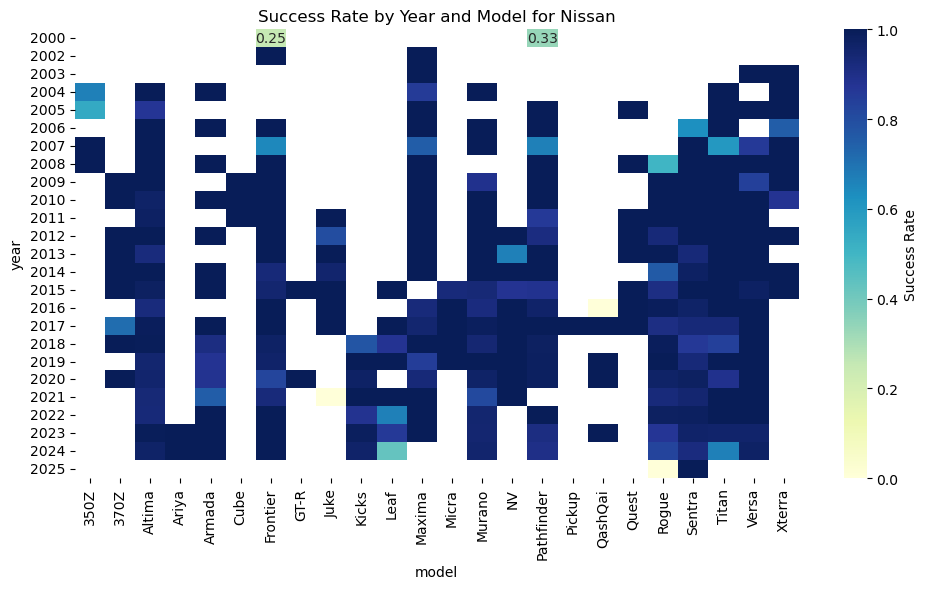

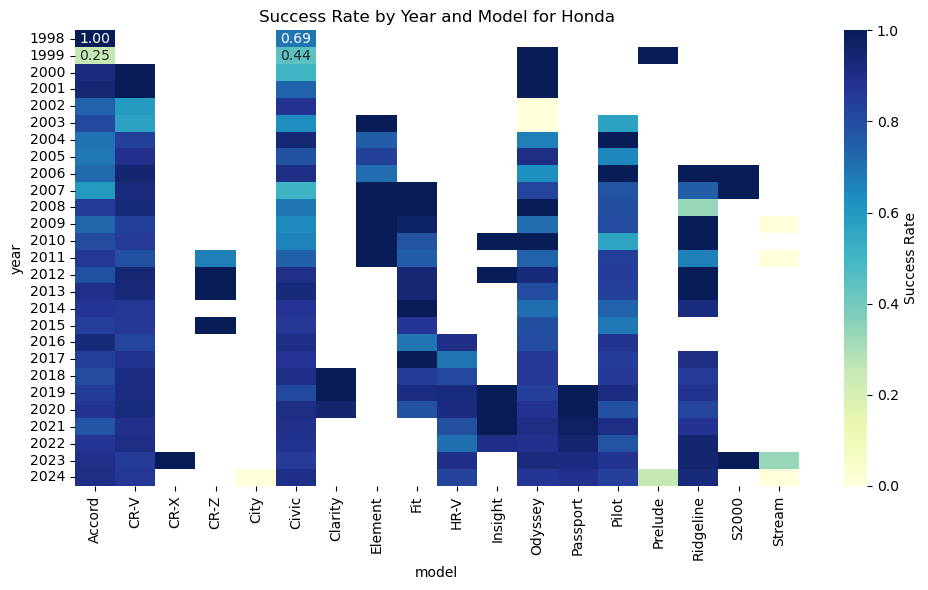

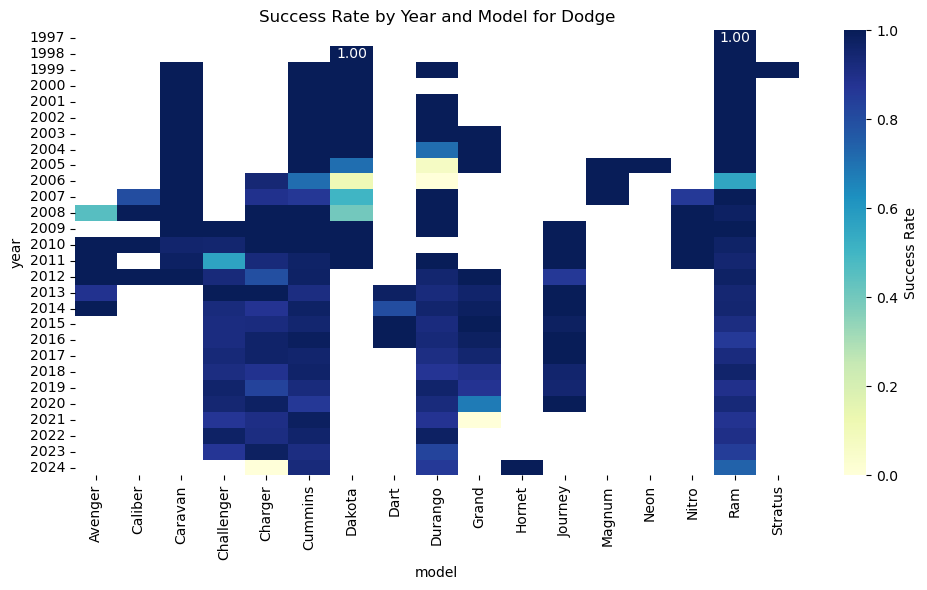

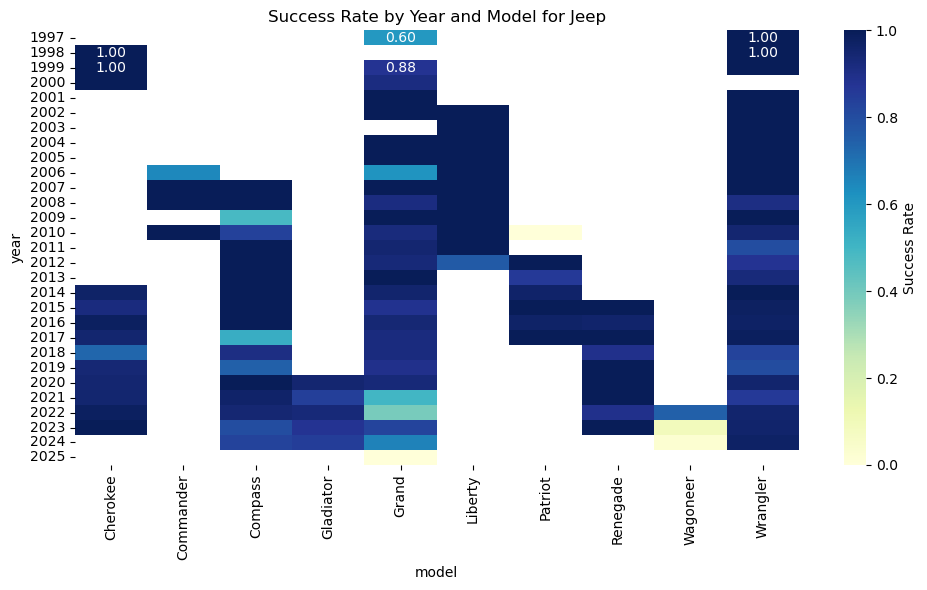

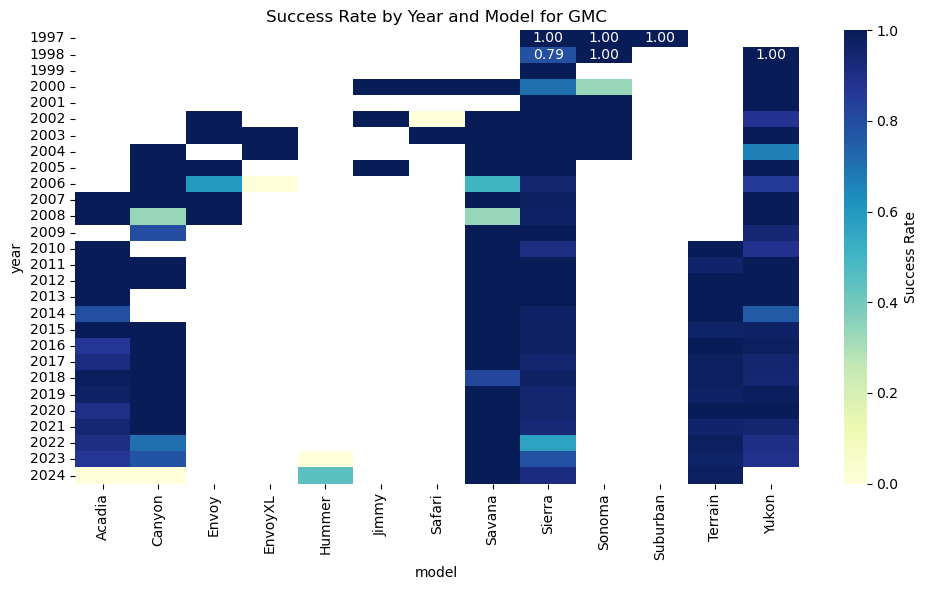

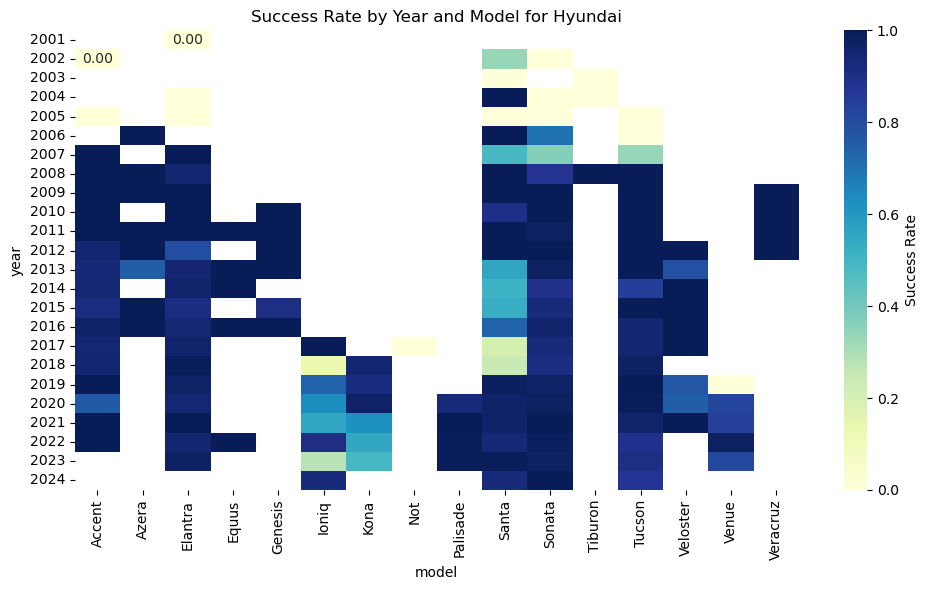

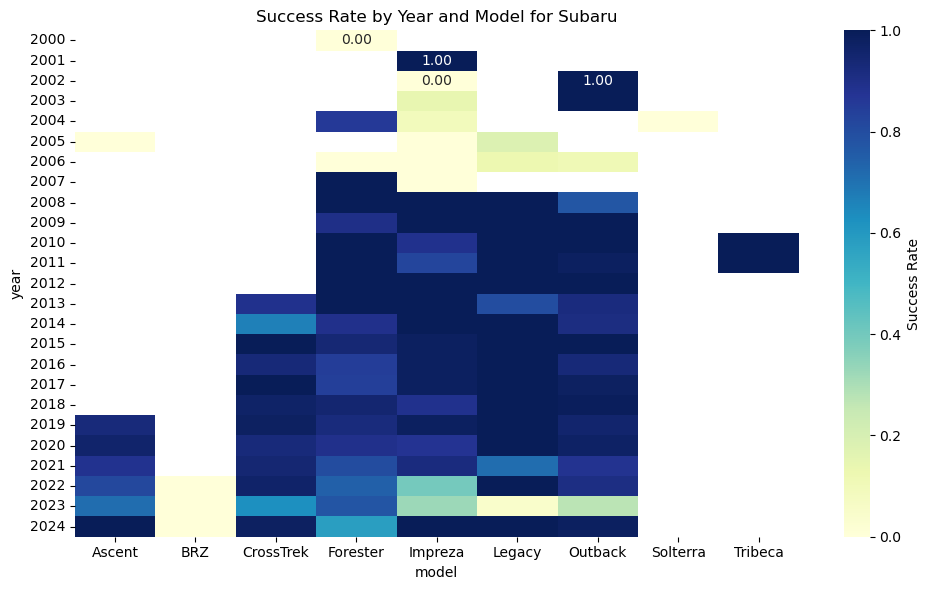

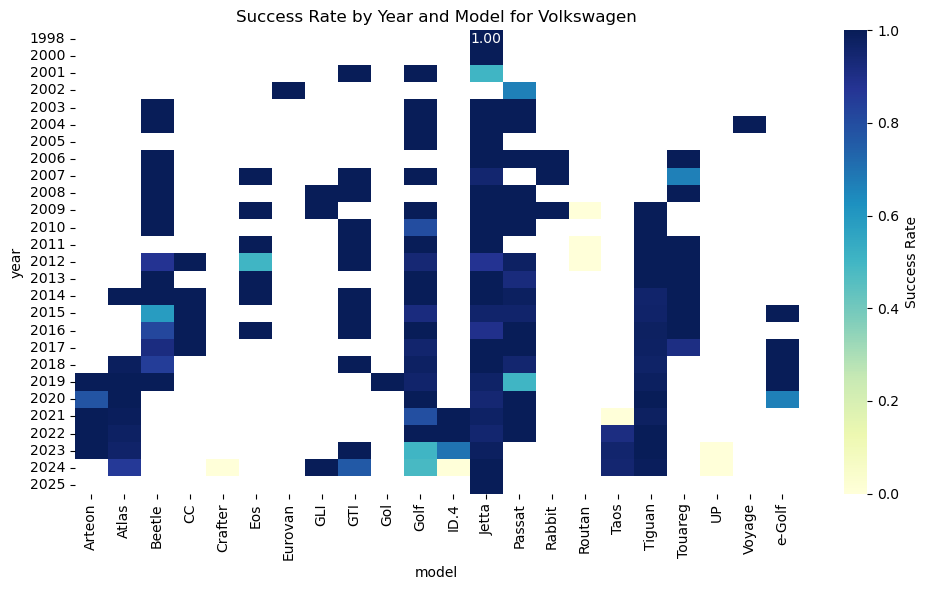

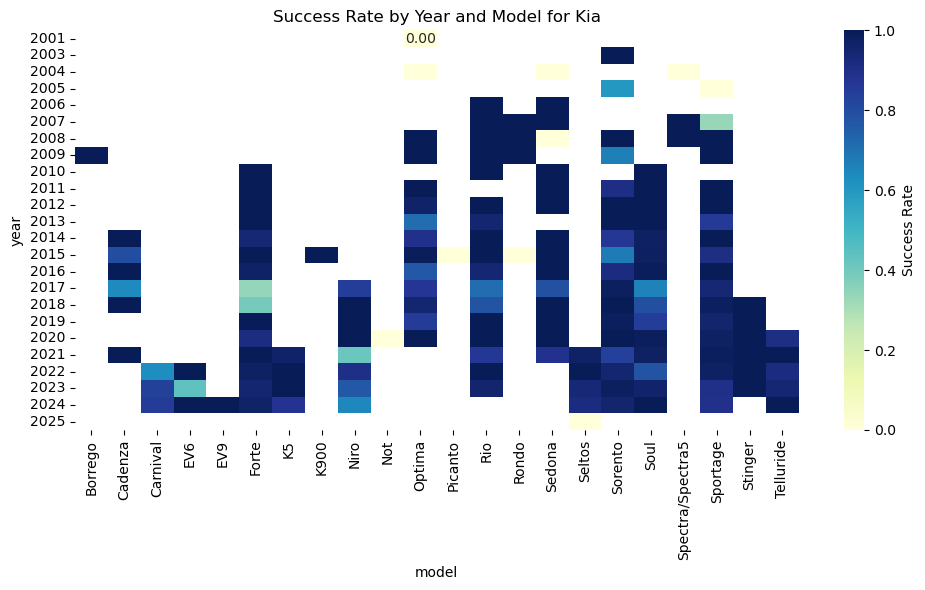

In [65]:
top_twelve_makes = ['Toyota', 'Ford', 'Chevrolet', 'Nissan', 'Honda', 'Dodge', 'Jeep', 'GMC', 'Hyundai', 'Subaru', 'Volkswagen', 'Kia']
for make in top_twelve_makes:
    make_df = vci_connections_df[vci_connections_df['make'] == make]
    create_contingency_table_results(make_df, 'model', 'year', f'Success Rate by Year and Model for {make}')

### Look at Make Toyota more closely
Toyota has the most number scans and the most number of failures. Find out which models and years are causing issues

In [157]:
toyota_df = vci_connections_df[vci_connections_df['make'] == 'Toyota']

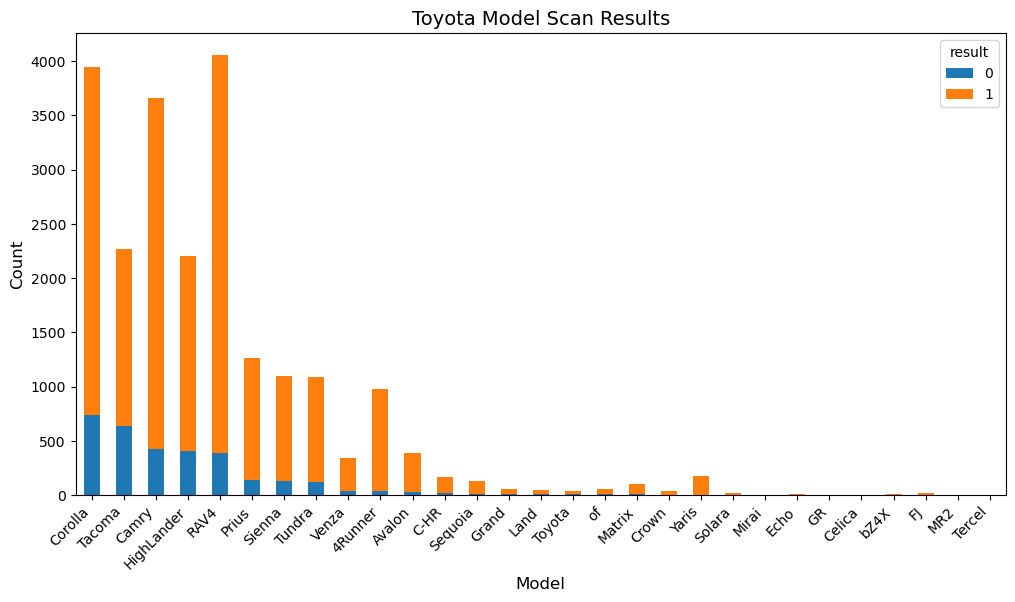

In [160]:
import matplotlib.pyplot as plt

grouped_df = toyota_df.groupby(["model", "result"]).size().unstack()
grouped_df = grouped_df.sort_values(by=0, ascending=False)

ax = grouped_df.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title("Toyota Model Scan Results", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.show()

In [190]:
tacoma_df = toyota_df[((toyota_df['model'] == 'Tacoma') | (toyota_df['model'] == 'Corolla')) & (toyota_df['year'] >= 2017)]

# Group by 'veh_desc' and calculate the sum and mean of 'result'
tacoma_df = (
    tacoma_df.groupby('veh_desc')['result']
    .agg(total_scans='count', mean_result='mean')
    .reset_index()
    .sort_values(by='mean_result', ascending=True)
)
tacoma_df = tacoma_df[(tacoma_df['mean_result'] < 0.75) & (tacoma_df['total_scans'] > 1)]
tacoma_df

,veh_desc,total_scans,mean_result
87,2024 Toyota Corolla Cross Brake EPB CAN,2,0.000000
103,2024 Toyota Tacoma ECT - Electronic Control Tr...,3,0.000000
12,2017 Toyota Tacoma Remote Engine Starter CAN,2,0.000000
79,2023 Toyota Corolla iM Enhanced Powertrain CAN,2,0.000000
69,2022 Toyota Tacoma PreCollision 2 CAN,3,0.000000
45,2021 Toyota Corolla Airbag SRS CAN,3,0.333333
104,2024 Toyota Tacoma Enhanced Powertrain CAN,130,0.484615
57,2022 Toyota Corolla Cross Brake EPB CAN,2,0.500000
26,2019 Toyota Corolla iM Enhanced Powertrain CAN,2,0.500000
4,2017 Toyota Tacoma ABS CAN,2,0.500000


In [166]:
model_failures_df = toyota_df.groupby('model')['result'].agg(
    num_failures=lambda x: (x == 0).sum(),  
    total_scans='count'  
).reset_index()

# Calculate failure percentage directly in the DataFrame
model_failures_df['failure_percentage'] = (model_failures_df['num_failures'] / model_failures_df['total_scans']) * 100

model_failures_df = model_failures_df.sort_values(by='num_failures', ascending=False)

model_failures_df.head(10)

,model,num_failures,total_scans,failure_percentage
5,Corolla,742,3942,18.822933
21,Tacoma,636,2266,28.067079
3,Camry,427,3662,11.660295
11,HighLander,405,2200,18.409091
17,RAV4,386,4055,9.519112
16,Prius,138,1267,10.891871
19,Sienna,131,1094,11.974406
24,Tundra,118,1087,10.855566
25,Venza,37,347,10.662824
0,4Runner,34,975,3.487179


#### Analysis of vehicle systems 
The vehicle system represents the physical ECU (Electronic Control Unit) of the vehicle. It is the end point of communications. 
Look at distribution of vehicle systems. Determine connection success rate for individual systems. Look at veh_desc / system and vin / system combinations

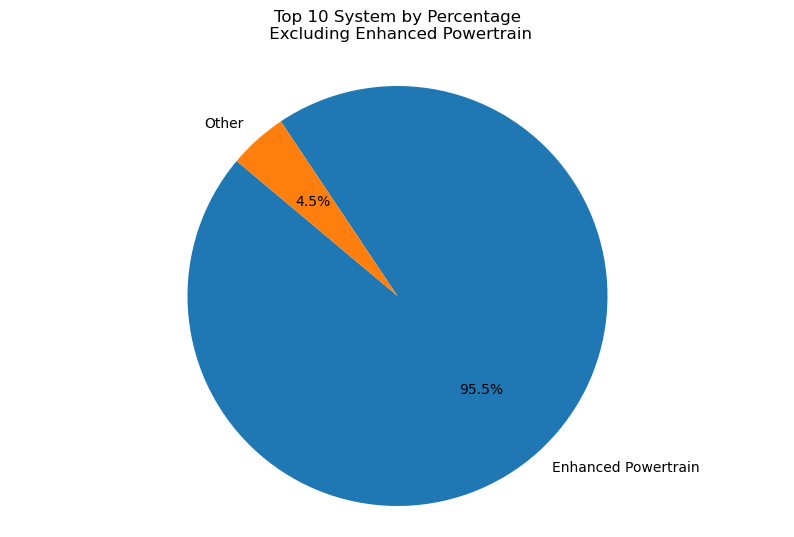

In [68]:
#Determine the percentage of each system category
system_counts_df = vci_connections_df['system_category']

#Change entries that are not 'Enhanced Powertrain' to 'Other'
system_counts_df = system_counts_df.apply(lambda x: 'Other' if x != 'Enhanced Powertrain' else x)
total_records = system_counts_df.shape[0]
system_counts = system_counts_df.value_counts()
system_counts_percent = system_counts / total_records * 100

#create a pie chart of top 10 values in system_counts_percent
top_10_systems = system_counts_percent.nlargest(10)
plt.figure(figsize=(10, 6))
plt.pie(top_10_systems, labels=top_10_systems.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 System by Percentage\n Excluding Enhanced Powertrain\n')
plt.axis('equal')  
plt.show()

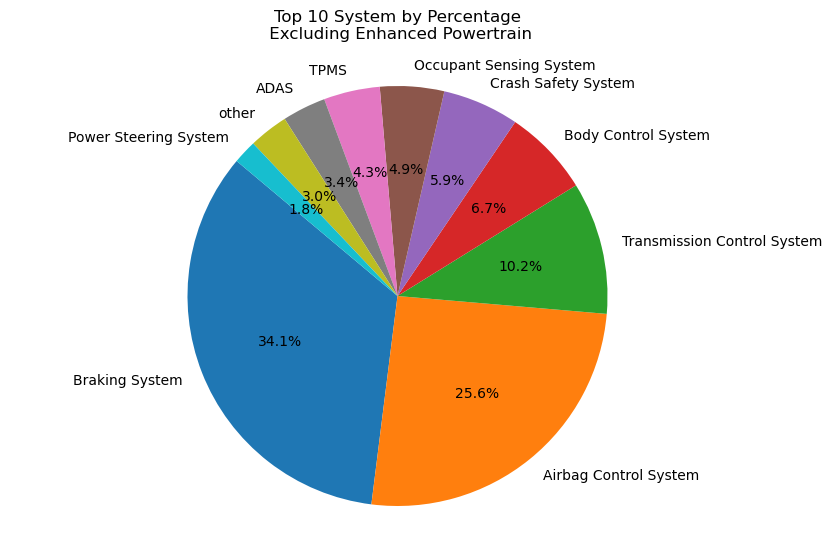

In [134]:
#Determine the percentage of each system category excluding the enhanced powertrain systems
system_counts_df = vci_connections_df[vci_connections_df['system_category'] != 'Enhanced Powertrain']['system_category']
total_records = system_counts_df.shape[0]
system_counts = system_counts_df.value_counts()
system_counts_percent = system_counts / total_records * 100

#create a pie chart of top 10 values in system_counts_percent
top_10_systems = system_counts_percent.nlargest(10)
plt.figure(figsize=(10, 6))
plt.pie(top_10_systems, labels=top_10_systems.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 System by Percentage\n Excluding Enhanced Powertrain\n')
plt.axis('equal')  
plt.show()

In [69]:
makes_dict = {'top_10_makes': ['Toyota', 'Ford', 'Chevrolet', 'Nissan', 'Honda', 'Dodge', 'Jeep', 'GMC', 'Hyundai', 'Kia'],
              'asian_makes': ['Acura', 'Genesis', 'Honda', 'Hyundai', 'Isuzu', 'Kia', 'Lexus', 'Mazda', 'Mitsubishi', 'Nissan', 'Scion', 'Subaru', 'Toyota'],
              'european_makes': ['Alfa-Romeo', 'Aston-Martin', 'Audi', 'Bentley', 'BMW', 'Fiat', 'Infiniti', 'Jaguar', 'Land-Rover', 'Mercedes-Benz', 'MINI', 'Porsche', 'Saab', 'Seat', 'SMART', 'Volkswagen', 'Volvo'],
              'domestic_makes': ['Ford', 'Chevrolet', 'Dodge', 'GMC', 'Chrysler', 'Buick', 'Cadillac', 'Lincoln', 'Hummer', 'Jeep', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Saturn' , 'Mercury'],
              'specialty_makes': ['Ferrari', 'Lamborghini', 'Maserati', 'McLaren']}

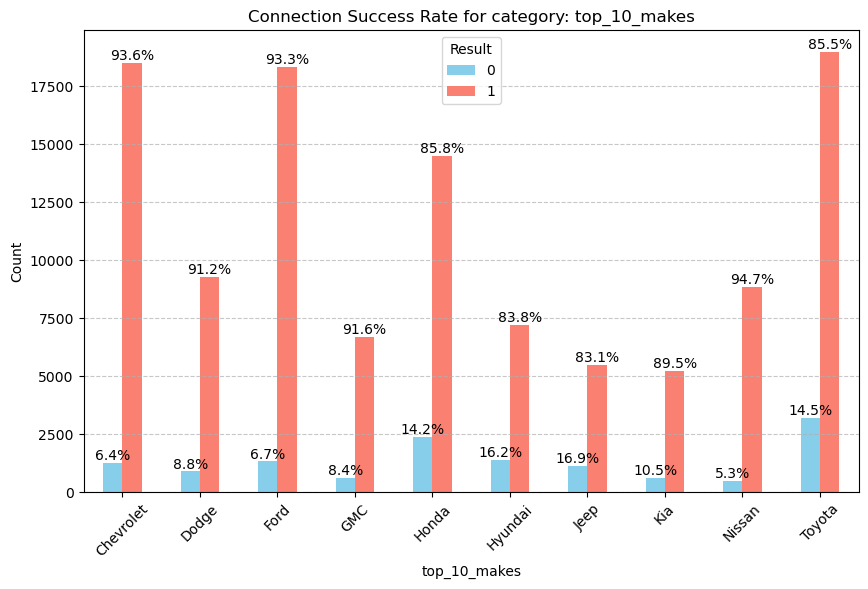

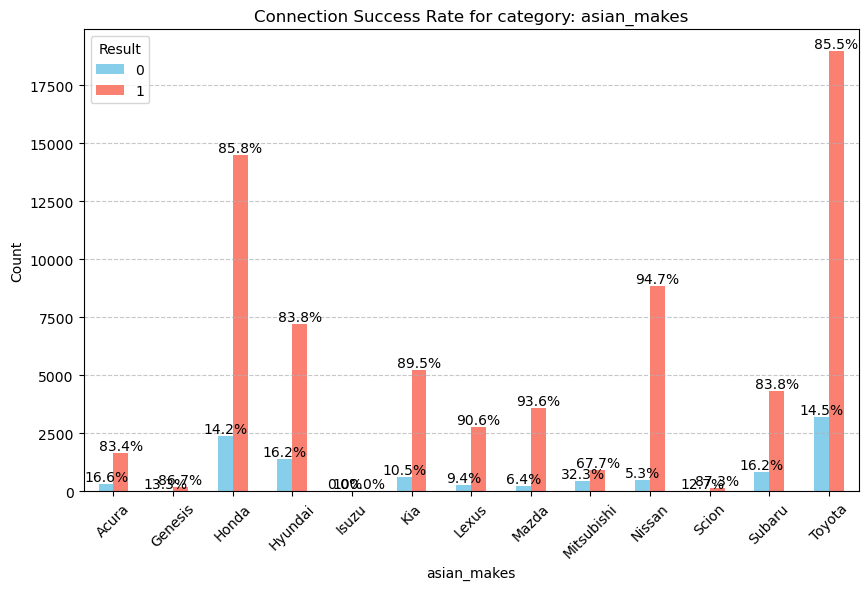

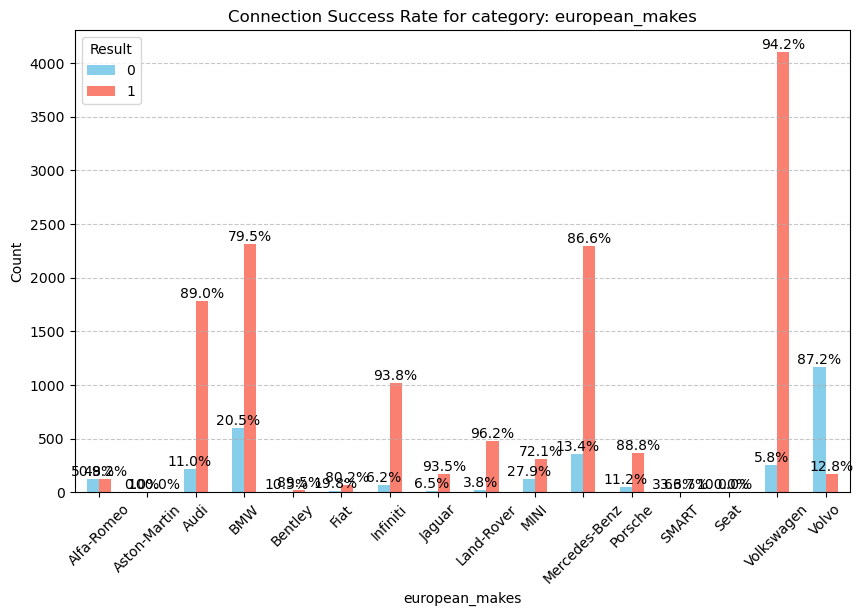

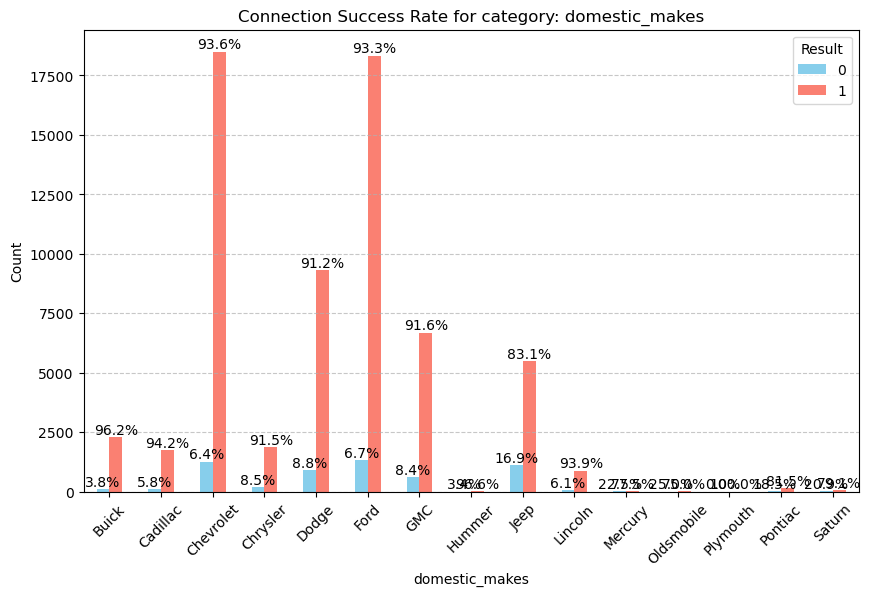

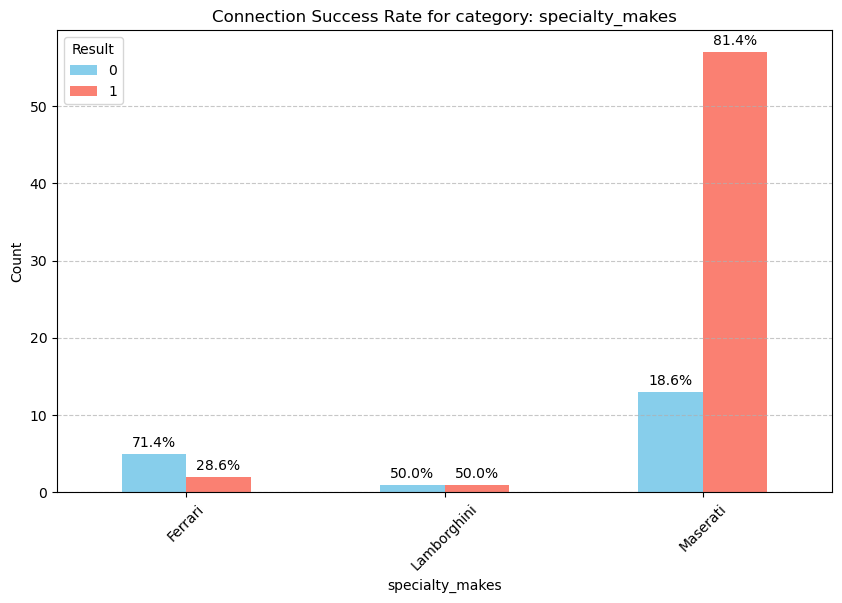

In [70]:
#plot the success rate by make category
for make_category, makes in makes_dict.items():
    makes_df = vci_connections_df[vci_connections_df['make'].isin(makes)]
    makes_df = pd.crosstab(makes_df['make'], makes_df['result'])
    percentages = makes_df.div(makes_df.sum(axis=1), axis=0) * 100
    ax = makes_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
    plt.title(f'Connection Success Rate for category: {make_category}')
    plt.xlabel(make_category)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Result')

    # Annotate percentages on the bars
    for bar_group, percentage_group in zip(ax.containers, percentages.T.iterrows()):
        for bar, percentage in zip(bar_group, percentage_group[1]):
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 0.5,  # Y-coordinate
                f'{percentage:.1f}%',  # Percentage text
                ha='center', va='bottom', fontsize=10  # Align text
            )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [154]:
#plot the success rate by make category
for make_category, makes in makes_dict.items():
    vci_connections_df.loc[vci_connections_df['make'].isin(makes), 'make_category'] = make_category
vci_connections_df['make_category'].value_counts()


make_category
asian_makes        78657
domestic_makes     71065
european_makes     16231
specialty_makes       79
Name: count, dtype: int64

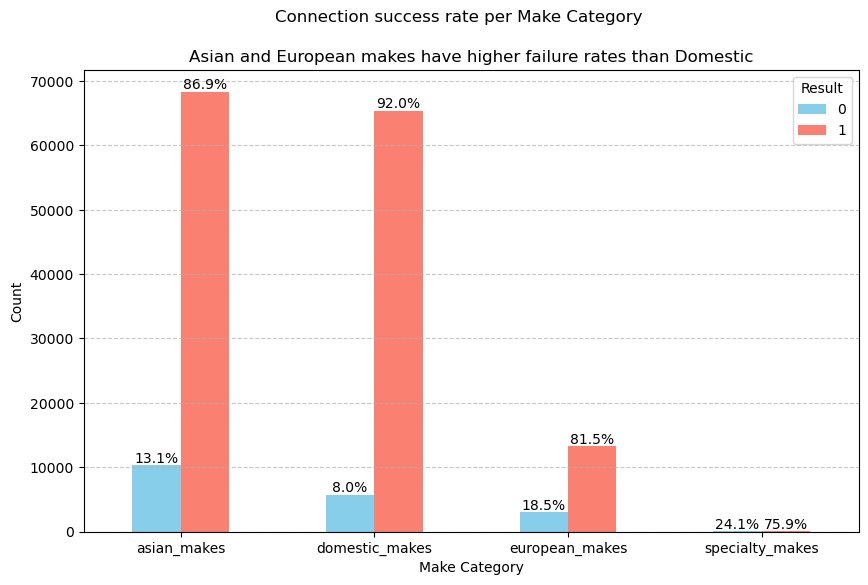

In [155]:

makes_df = pd.crosstab(vci_connections_df['make_category'], vci_connections_df['result'])
percentages = makes_df.div(makes_df.sum(axis=1), axis=0) * 100
ax = makes_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.suptitle(f'Connection success rate per Make Category')
plt.title(f'Asian and European makes have higher failure rates than Domestic')
plt.xlabel('Make Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Result')

# Annotate percentages on the bars
for bar_group, percentage_group in zip(ax.containers, percentages.T.iterrows()):
    for bar, percentage in zip(bar_group, percentage_group[1]):
        ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 0.5,  # Y-coordinate
                f'{percentage:.1f}%',  # Percentage text
                ha='center', va='bottom', fontsize=10  # Align text
        )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Analysis of scanning success rates for unique VIN system combinations.
The success rate for each unique combination of vin and system. Using the vehicles VIN will give the most fine grained resolution in vehicle groupings. The vin contains more detailed information about each vehicle variant such as engine type, engine size, body type, etc. A grouping of make, model, year, system may contain many VINs. 
#### Note: The VIN can mapped back to a Make, Model, Year, System combination

In [83]:
#The number of failed and successful connections will be modified for lower number of scans
def compute_confidence_interval(row, alpha=0.05):
    ci_low, ci_upp = sm.stats.proportion_confint(
        count=row['num_success'], 
        nobs=row['total_scans'], 
        alpha=alpha, 
        method='wilson'
    )
    return pd.Series({'ci_low': ci_low, 'ci_upp': ci_upp})

In [86]:
vin_plus_system_df = vci_connections_df.groupby(['vin', 'system_category']).apply(
    lambda group: pd.Series({
        'num_success': group['result'].sum(),                # Total successful scans
        'total_scans': group['result'].count(),                    # Total scans
        'num_veh': group['veh_desc'].nunique(),                  # How many vehicle descriptions
        'num_successful_shops': group.loc[group['result'] == 1, 'siteId'].nunique(),
        'num_failed_shops': group.loc[group['result'] == 0, 'siteId'].nunique()
    })
).reset_index().sort_values(by='total_scans', ascending=False)

vin_plus_system_df['success_rate'] = vin_plus_system_df['num_success'] / vin_plus_system_df['total_scans'] * 100
vin_plus_system_df['failure_rate'] = 100 - vin_plus_system_df['success_rate']

ci_values = vin_plus_system_df.apply(compute_confidence_interval, axis=1)
vin_plus_system_df = pd.concat([vin_plus_system_df, ci_values], axis=1)
vin_plus_system_df.head()

,vin,system_category,num_success,total_scans,num_veh,num_successful_shops,num_failed_shops,success_rate,failure_rate,ci_low,ci_upp
12486,1G8AJ52F84Z,Enhanced Powertrain,41,41,1,1,0,100.000000,0.000000,0.914332,1.000000
10220,1FTPW12536F,Enhanced Powertrain,41,41,1,1,0,100.000000,0.000000,0.914332,1.000000
38733,4T1BF1FK6HU,Enhanced Powertrain,30,40,1,14,1,75.000000,25.000000,0.598060,0.858129
21567,1YVHP82A995,Enhanced Powertrain,33,38,1,1,1,86.842105,13.157895,0.726731,0.942461
53578,JTDKAMFUXN3,Enhanced Powertrain,25,36,1,4,1,69.444444,30.555556,0.531437,0.819955


In [87]:
vin_plus_system_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
num_success,65668.0,2.24,2.07,0.0,1.00,2.00,3.00,41.00
total_scans,65668.0,2.53,2.37,1.0,1.00,2.00,3.00,41.00
num_veh,65668.0,1.05,0.25,1.0,1.00,1.00,1.00,9.00
num_successful_shops,65668.0,1.29,0.89,0.0,1.00,1.00,1.00,15.00
num_failed_shops,65668.0,0.12,0.34,0.0,0.00,0.00,0.00,5.00
success_rate,65668.0,92.34,24.01,0.0,100.00,100.00,100.00,100.00
failure_rate,65668.0,7.66,24.01,0.0,0.00,0.00,0.00,100.00
ci_low,65668.0,0.31,0.15,0.0,0.21,0.34,0.44,0.91
ci_upp,65668.0,0.97,0.09,0.1,1.00,1.00,1.00,1.00


In [89]:
threshold = vin_plus_system_df['success_rate'].quantile(0.25)
intermittent_vehicles = vin_plus_system_df[(vin_plus_system_df['success_rate'] > 0) & (vin_plus_system_df['success_rate'] < threshold)]
intermittent_vehicles.shape

(4204, 11)

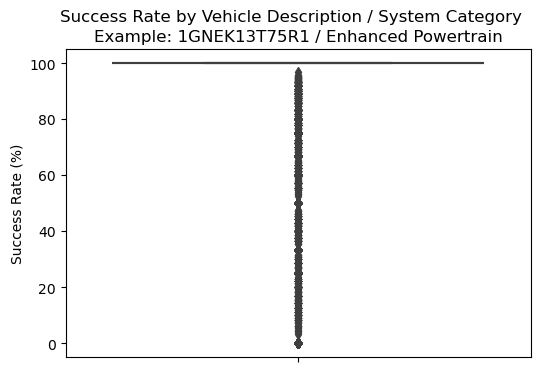

In [90]:
#create boxplot of success_rate for vin_system_df
plt.figure(figsize=(6, 4))
sns.boxplot(data=vin_plus_system_df, y='success_rate', orient='v')
plt.suptitle('Success Rate by Vehicle Description / System Category')
plt.title('Success Rate by VIN and System Category')
plt.title('Example: 1GNEK13T75R1 / Enhanced Powertrain')
plt.ylabel('Success Rate (%)')
plt.show()

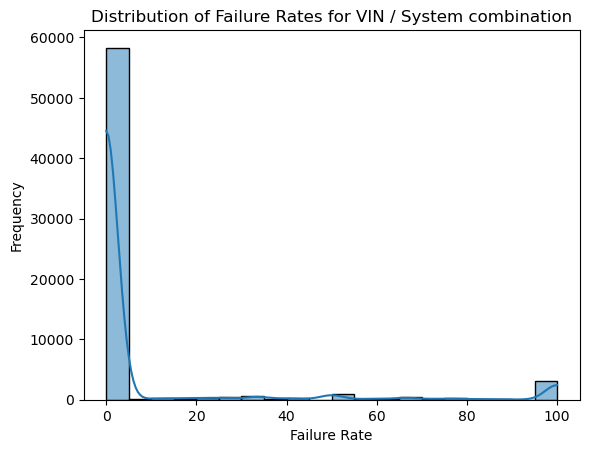

In [91]:
#create distribution of failure rate
sns.histplot(vin_plus_system_df['failure_rate'], kde=True, bins=20)
#add title and labels
plt.xlabel('Failure Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Failure Rates for VIN / System combination')
plt.show()

In [92]:
#find entries that account for passed in percentage of of scans. Assumes passed in dataframe has a 'total' column
def get_entries_for_percentage(df, threshold):
    total = df['total'].sum()
    #sort the dataframe
    df = df.sort_values(by='total', ascending=False)
    #get the cumulative total for each unique vehicle / system combination
    df['cumulative_total'] = df['total'].cumsum()
    #get the cumulative percentage for each unique vehicle / system combination
    df['cumulative_pct'] = df['cumulative_total'] / total * 100
    idx = np.argmax(df['cumulative_pct'] >= threshold)
    return df.iloc[:idx+1]

## Investigate scan success rates between different connection methods for different makes
#### The diagnostics tool supports two connection methods, Manual Scan and Quick Scan. For Quick Scan, the tool attempts to learn the vehicle attributes (year, make, model, engine, transmission, etc) automatically by interagating the vehicle. For Manual Scan, the user enters these values manually from drop down menus. It has been assumed that manually selecting the vehicle options will give a higher connection success rate especially for makes such as BMW.

In [77]:
#Create dataframe that shows number of scan by each scanning type
make_scan_df = vci_connections_df.groupby(['make', 'scan_method']).apply(
    lambda group: pd.Series({
    'successes': group['result'].sum(),                # Total successful scans
    'failures': group.loc[group['result'] == 0, 'result'].count(),                # Total failed scans
    'total': group['result'].count(),                    # Total scans
    'successful_shops': group.loc[group['result'] == 1, 'siteId'].nunique(),
    'failed_shops': group.loc[group['result'] == 0, 'siteId'].nunique()})).reset_index()
#make_scan_df.sample(5)

In [78]:
#Get the success rate and failure rate for each make and scan method
make_scan_df['success_rate'] = make_scan_df['successes'] / make_scan_df['total'] * 100
make_scan_df['failure_rate'] = make_scan_df['failures'] / make_scan_df['total'] * 100
make_scan_df.sample(5)

,make,scan_method,successes,failures,total,successful_shops,failed_shops,success_rate,failure_rate
29,Genesis,manual scan,51,10,61,27,4,83.606557,16.393443
47,Land-Rover,manual scan,139,3,142,68,3,97.887324,2.112676
22,Ferrari,quick_scan,1,1,2,1,1,50.000000,50.000000
41,Jaguar,quick_scan,135,8,143,68,6,94.405594,5.594406
28,GMC,quick_scan,4841,423,5264,639,109,91.964286,8.035714


In [79]:
#pivot on the make column
make_scan_pivot_df = make_scan_df.pivot(index='make', columns='scan_method', values=['success_rate', 'failure_rate', 'total'])

#Determine the differences between quick_scan and manual scan success and failure rates
make_scan_pivot_df['success_rate_diff'] = make_scan_pivot_df['success_rate']['quick_scan'] - make_scan_pivot_df['success_rate']['manual scan']

#success and failure rate differences are the same value with opposite sign we can just use the success rate difference
#make_scan_pivot_df['failure_rate_diff'] = make_scan_pivot_df['failure_rate']['quick_scan'] - make_scan_pivot_df['failure_rate']['manual scan']

make_scan_pivot_df = make_scan_pivot_df.reset_index()

#sort by absolute value of success rate difference
make_scan_pivot_df = make_scan_pivot_df.sort_values(by='success_rate_diff', ascending=False)

#Only keep samples for makes with at least 50 total scans
make_scan_pivot_df['total_scans'] = make_scan_pivot_df['total']['manual scan'] + make_scan_pivot_df['total']['quick_scan']
mask = make_scan_pivot_df['total_scans'].fillna(0) > 50
make_scan_pivot_df = make_scan_pivot_df[mask]

#used to highlight makes with lower scans
make_scan_pivot_df['inv_total_scans'] = make_scan_pivot_df['total_scans'].max() - make_scan_pivot_df['total_scans'] + 1
make_scan_pivot_df['total_scans_adj'] = (make_scan_pivot_df['total_scans'] * 10) + 5

make_scan_pivot_df.sample(10)


make success_rate            failure_rate             \
scan_method                 manual scan quick_scan  manual scan quick_scan   
12                    Fiat    62.500000  91.836735    37.500000   8.163265   
19                Infiniti    97.744361  92.570037     2.255639   7.429963   
31           Mercedes-Benz    84.078212  87.564499    15.921788  12.435501   
33              Mitsubishi    66.843501  68.032787    33.156499  31.967213   
15                 Genesis    83.606557  87.804878    16.393443  12.195122   
37                 Pontiac    97.619048  75.833333     2.380952  24.166667   
1               Alfa-Romeo    58.823529  46.700508    41.176471  53.299492   
23                     Kia    91.493637  88.807171     8.506363  11.192829   
45              Volkswagen    93.396226  94.474803     6.603774   5.525197   
21                  Jaguar    90.243902  94.405594     9.756098   5.594406   

                  total            success_rate_diff total_scans  \
scan_method manual scan quick_scan                                 
12                 32.0       49.0         29.336735        81.0   
19                266.0      821.0         -5.174324      1087.0   
31                716.0     1938.0          3.486287      2654.0   
33                377.0      976.0          1.189286      1353.0   
15                 61.0      164.0          4.198321       225.0   
37                 42.0      120.0        -21.785714       162.0   
1                  51.0      197.0        -12.123022       248.0   
23               1493.0     4351.0         -2.686466      5844.0   
45               1060.0     3294.0          1.078576      4354.0   
21                 41.0      143.0          4.161692       184.0   

            inv_total_scans total_scans_adj  
scan_method                                  
12                  22098.0           815.0  
19                  21092.0         10875.0  
31                  19525.0         26545.0  
33                  20826.0         13535.0  
15                  21954.0          2255.0  
37                  22017.0          1625.0  
1                   21931.0          2485.0  
23                  16335.0         58445.0  
45                  17825.0         43545.0  
21                  21995.0          1845.0

In [80]:
#makes_df.head()
#rename 1 column to success
fig = px.scatter(make_scan_pivot_df, x='make', y='success_rate_diff', color="make",
                hover_data={'make', 'total_scans'},
                size='total_scans_adj',
                size_max=50,
                color_continuous_scale='Viridis',
                title="Vehicle Make Success Rate Differences: Quick Scan vs. Manual Scan (Size of marker represents total scans)")
fig.show()

## Investigate scanning results based on OS of mobile application
It is assumed that the operating system used to perform a scan will not affect the scanning rate. We will double check this to make sure. Any differences would be due to communication issues between the scantool and mobile application. The Note: iOS represents iPad and iPadOS represents iPhones

In [103]:
# Look at application usage by OS
os_name_counts = vci_connections_df['OsName'].value_counts()

fig = px.pie(
    os_name_counts,
    values=os_name_counts.values,
    names=os_name_counts.index,
    hole=0,  
)

# Show labels with both percentage and count
fig.update_traces(textinfo='label+percent+value')
fig.update_layout(showlegend=False)

# Show the figure
fig.show()

In [74]:
#calculate success rate for each OS
os_success_rate = vci_connections_df.groupby('OsName')['result'].mean()
os_success_rate

OsName
Android    0.885690
Windows    0.886807
iOS        0.880815
iPadOS     0.883631
Name: result, dtype: float64

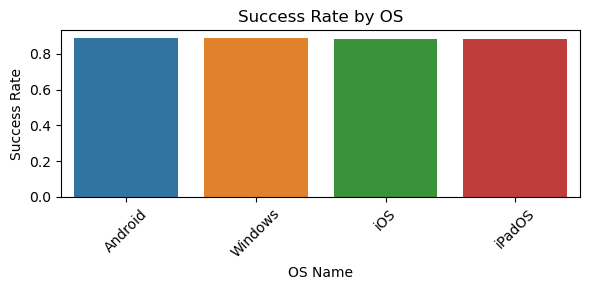

In [96]:
# bar plot of success rate by OS
plt.figure(figsize=(6, 3))
sns.barplot(x=os_success_rate.index, y=os_success_rate.values)
plt.title('Success Rate by OS')
plt.xlabel('OS Name')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


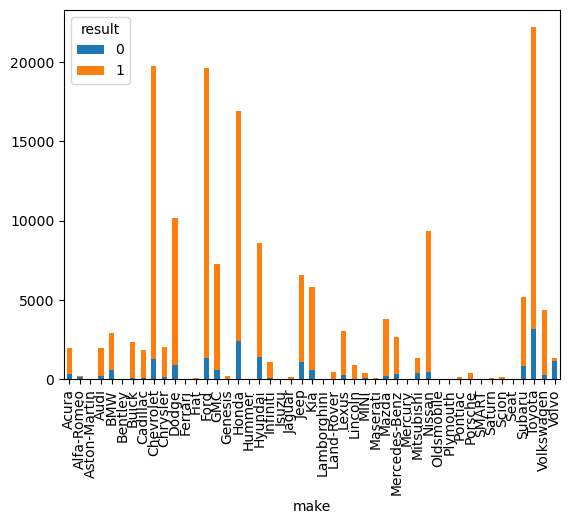

In [94]:
vci_connections_df.groupby(["make", "result"]).size().unstack().plot(kind='bar', stacked=True)
plt.show()